#Structured Denoising Diffusion Models in Discrete State-Spaces (D3PMs)

In this notebook, the implementation of D3PMs [paper](https://arxiv.org/abs/2107.03006) will be presented,
the paper tackles  diffusion for discrete data, A lot of the data is inherently discrete, even though data like text which can be represented in a discrete way for instance random variable x could be one of the categories = {a,b,c ....z} or even {token1, token2, token3 .... token n}and something like an image each pixel could have a categorical value = {0,1,2 .... 255}


\

The first section will go over the implementation details in depth using a 2d data example and the second section will take the image generation task as an example



#Author Information
Salahedin Mohamed

Email:  samo00008@stud.uni-saarland.de



##Table of Contents

1. First Section (implementation in depth on 2d Data)
   - 1.1 Creating base model and dataset
   - 1.2 Forward Process
      - Defining transition matrix
      - Implementation and visualization of the Q matrix
      - Implementation and visualization of forward process
   - 1.3 Reverse Process
   - 1.4 Loss Parameterization
      - Two loss terms
      - Training
2.  Image generation

3.  Conclusion








In [1]:
# @title Install dependencies
!pip install pytorch-lightning
!pip install einops
!pip install lightning

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 801.6/801.6 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 841.5/841.5 kB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 42.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 36.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 64.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 15.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━

In [2]:
# @title Imports
import argparse
import os

import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from tqdm.auto import tqdm

import matplotlib.pyplot as plt
import numpy as np

import argparse
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
from torch.utils.data import TensorDataset

import einops

from tqdm import tqdm
from torchvision.utils import save_image, make_grid
from matplotlib.animation import FuncAnimation, PillowWriter
import torchvision.transforms as transforms
from torch.utils.data import Dataset
from PIL import Image
import sys

import argparse
import lightning.pytorch as pl
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm  # Import tqdm for the progress bar




#**First Section**

First we need to have some dataset, we will build a 2d spiral dataset first.  the dataset consists of 2d points and the distribution of the 2d points when plotted looks like a spiral

In [3]:
def spiral_dataset(return_np=False):
    """Build a spiral 2d dataset.
    Returns:
       Torch dataset with shape `( , 2)`

    """
    spiral = []
    max_radius = 100
    for angle in range(0, int(360*1.5)):  # 1.5 loops around the center
        radius = math.sqrt(angle)  # Increasing radius
        x = int(radius * math.cos(math.radians(angle)))
        y = int(radius * math.sin(math.radians(angle)))
        if abs(x) <= max_radius and abs(y) <= max_radius:
            spiral.append([x, y])
    spiral = np.array(spiral)


    rng = np.random.default_rng(42)
    ix = rng.integers(0, len(spiral),700)
    x = spiral[:,0]
    x = np.array(x) + rng.normal(size=len(x))+50 # make all values between 0 and 100

    y =spiral[:,1]
    y = np.array(y) + rng.normal(size=len(x))   +50  # make all values between 0 and 100


    X = np.stack((x.astype(int)
    , y.astype(int)
    ), axis=1)

    if return_np:
        return X

    return TensorDataset(torch.from_numpy(X.astype(np.float32)))

let's visualizalize how it looks

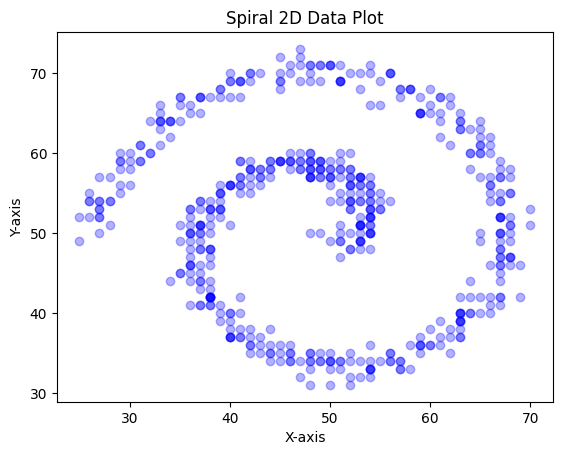

In [4]:
def plot(X ,title='Spiral 2D Data Plot'):
    # Extracting x and y coordinates
  x = X[:, 0][0]
  y = X[:, 1][0]
  plt.scatter(x, y, color='blue', alpha=0.3)
  plt.title(title)
  plt.xlabel('X-axis')
  plt.ylabel('Y-axis')
  plt.grid(False)
  plt.show()

plot(spiral_dataset())

#Base Model
Now we need to define the base model, since this is 2d data I will use a relatively simple model

keypoints:
- I used Sinusoidal Embedding for the t (step no) more about it [here](https://medium.com/nlp-trend-and-review-en/positional-embeddings-7b168da36605)
- the final layer has the shape (batch_size ,2, num_bins)  where 2 because it's 2d data and num_bins or number of categories to have one hot encoding output on all categories

base model was based on the one in [here](https://github.com/tanelp/tiny-diffusion) and modified to be suitable for discrete data


In [5]:


class Block(nn.Module):
    def __init__(self, size: int):
        super().__init__()

        self.ff = nn.Linear(size, size)
        self.b = nn.BatchNorm1d(size)
        self.act = nn.GELU()

    def forward(self, x: torch.Tensor):
        return x + self.act(self.b(self.ff(x)))


def get_timestep_embedding(timesteps, embedding_dim=20, max_time=1000., dtype=torch.float32):
    """Build sinusoidal embeddings

    Args:
        timesteps: torch.Tensor: generate embedding vectors at these timesteps
        embedding_dim: int: dimension of the embeddings to generate
        max_time: float: largest time input
        dtype: data type of the generated embeddings

    Returns:
        embedding vectors with shape `(len(timesteps), embedding_dim)`

    """

    timesteps = timesteps.squeeze(1)
    assert len(timesteps.shape) == 1
    timesteps *= (1000. / max_time)

    half_dim = embedding_dim // 2
    emb = torch.log(torch.tensor(10000.)) / (half_dim - 1)
    emb = torch.exp(torch.arange(half_dim, dtype=dtype) * -emb).to(device)

    emb = timesteps.unsqueeze(1).type(dtype) * emb.unsqueeze(0)
    emb = torch.cat([torch.sin(emb), torch.cos(emb)], dim=1)
    if embedding_dim % 2 == 1:  # zero pad
        emb = torch.nn.functional.pad(emb, (0, 0, 0, 1, 0, 0))
    assert emb.shape == (timesteps.shape[0], embedding_dim)
    return emb

class MLP(nn.Module):
    def __init__(self,num_bins= 20, hidden_size: int = 64, hidden_layers: int = 2, emb_size: int = 20,
                 time_emb: str = "sinusoidal", input_emb: str = "sinusoidal"):
        super().__init__()

        self.input_mlp1 = nn.Embedding(num_embeddings=100, embedding_dim=emb_size)  # for embedding x
        self.input_mlp2 =  nn.Embedding(num_embeddings=100, embedding_dim=emb_size)    # for embedding y

        self.num_bins = num_bins

        concat_size = (emb_size) *2

        layers = [nn.Linear(concat_size, hidden_size), nn.GELU()]
        for _ in range(hidden_layers):
            layers.append(Block(hidden_size))


        layers.append(nn.Linear(hidden_size, 2 *num_bins ))


        self.joint_mlp = nn.Sequential(*layers)

    def forward(self, x, t):
        x1_emb = self.input_mlp1(x[:, 0].long())
        x2_emb = self.input_mlp2(x[:, 1].long())
        t_emb = get_timestep_embedding(t)
        # print(t_emb.shape,x2_emb.shape, x1_emb.shape )
        t_emb = t_emb.squeeze(1)
        x = torch.cat((x1_emb+t_emb, x2_emb+t_emb), dim=-1)  # adding the time embeddings works better that concatenating it
        x = self.joint_mlp(x)
        x = torch.reshape(x,(-1,2,self.num_bins))
        return x


# some constants

In [6]:
nb_time_steps = 200  # number of time steps for diffusion
num_bins = 100   # don't change, the dataset is configured to return on this no
eps = 1e-6     # small constant


# Forward Process


Below is a refined version of your description:

Let's delve into how the forward process unfolds.

Firstly, it's essential to grasp the nature of this model—it operates as a diffusion model on discrete data. For each discrete random variable X, it encompasses K categories, where each observation $x_t$, $x_{t-1}$ resides within the range of 1 to K.

In our two 2d spiral example X is 2 dimentional (x,y), x and y both belongs to range [0,100] which are also the K categories

This framework allows us to establish a transition matrix. The matrix assumes a shape of (K, K), with each entry Q[i][j] representing the probability of transitioning from category $K_i$ to $K_j$.

In essence, the Q matrix embodies a Markov transition matrix for discrete variables. Each row i and column j encapsulates the probability of transitioning from category i to j.




![](https://raw.githubusercontent.com/Salaheldinyoussry/d3pm_implementation/main/Screenshot%20from%202024-02-09%2010-29-18.png)



The forward process can be conceptualized as a corruption mechanism, wherein a discrete variable's categorical value undergoes transformation (i.e., changes to another categorical value). To facilitate this transformation, we leverage the Q matrix, which encapsulates the transition probabilities for such corruptions.

In practical terms, if we represent the discrete variable x in one-hot encoding and multiply it by the transition matrix Q (i.e., $xQ$), we derive a transition probability vector, denoted as p. This vector p delineates the likelihood of transitioning from one categorical value to another.

Given that the nature of diffusion-based corruption is dependent on the timestep, we employ a series of T Q matrices, denoted as {$Q_{1}$, $Q_{2}$, ..., $Q_{T}$}, where each matrix corresponds to a specific timestep.

Lastly, we define a forward function q(${x_t}|x_{t-1}$) to encapsulate this process. Mathematically, it can be expressed as:

$$q({x_t}|x_{t-1}) = Cat(x_t; p=x_{t-1} Q_t)  $$


In this equation, Cat(x; p) represents a categorical distribution over the one-hot vector x, with probabilities dictated by the row vector p. In simpler terms, we sample the new value of x_t using the probabilities outlined in vector p. This process ensures that each categorical transition is governed by the probabilities encoded in the Q matrix corresponding to the respective timestep.


Note that the corruption is done independently of each variable so in our two 2d spiral example X is 2 dimensional (x,y), x and y will corrupt independently of each other



First let's start with the noise schedule function, it's a simple function that takes an argument of the timesteps and returns the Betas (similar to continuous case), you can think of beta as a corruption probability when you are closer to the final forward diffusion step the prob increases, the rate in which the betas increase in this function is based on cosine schedule


In [7]:

def generate_beta_t(array_t):
    """
    Returns the beta_t values for each time step.
    It's a Cosine schedule.
    """

    timesteps = array_t.shape[0]

    steps = (
        torch.arange(timesteps + 1, dtype=torch.float64) /
        timesteps)
    alpha_bar = torch.cos((steps + 0.008) / 5.008 * torch.tensor(np.pi / 2, dtype=torch.float64))
    betas = torch.minimum(1 - alpha_bar[1:] / alpha_bar[:-1], torch.tensor(0.999, dtype=torch.float64))
    return betas






Then we need to define the transition matrix $Q_{t}$ given the beta schedule and the timestep.

the transition matrix can have multiple types, we can have a uniform transition i.e. each category can transition to any of the others uniformly, In another case maybe we can define an absorbing category all categories transition to it only.
see the following figure:

![Image Description](https://raw.githubusercontent.com/Salaheldinyoussry/d3pm_implementation/ca0ec689d645bc6e3d4688cc4a5a197a5e21a8b7/Screenshot%20from%202024-02-08%2011-15-19.png
)


Now the Q matrix is plotted to :

the values plot (the closer to one the yellowish it gets)
![Image Description](https://raw.githubusercontent.com/Salaheldinyoussry/d3pm_implementation/ca0ec689d645bc6e3d4688cc4a5a197a5e21a8b7/Screenshot%20from%202024-02-08%2011-17-07.png)


First, in the uniform matrix case, notice that the transitions are uniform

![Image Description](https://raw.githubusercontent.com/Salaheldinyoussry/d3pm_implementation/ca0ec689d645bc6e3d4688cc4a5a197a5e21a8b7/Screenshot%20from%202024-02-08%2011-16-44.png)


Second, in the Absorbing matrix case, notice that the transitions are uniform


![Image Description](https://raw.githubusercontent.com/Salaheldinyoussry/d3pm_implementation/ca0ec689d645bc6e3d4688cc4a5a197a5e21a8b7/Screenshot%20from%202024-02-08%2011-17-01.png)






In [8]:

def make_uniform_mat( t, betas, num_bins):
  """Computes transition matrix for q(x_t|x_{t-1}).

  construct a transition Q_t matrix with uniform probability to all other states.

  Args:
    t: timestep. integer scalar.

  Returns:
    Q_t: transition matrix. shape = (num_bins, num_bins).
  """
  beta_t = betas[t].numpy()



  mat = np.full(shape=(num_bins, num_bins),
                fill_value=beta_t/float(num_bins),
                dtype=np.float64)
  diag_indices = np.diag_indices_from(mat)
  diag_val = 1. - beta_t * (num_bins-1.)/num_bins
  mat[diag_indices] = diag_val


  return mat



def make_absorb_mat( t, betas, num_bins):
  """Computes transition matrix for q(x_t|x_{t-1}).

  construct a transition Q_t matrix with an absorbing state.

  Args:
    t: timestep. integer scalar.

  Returns:
    Q_t: transition matrix. shape = (num_bins, num_bins).
  """


  beta_t = betas[t].numpy()


  diag = np.full(shape=(num_bins,), fill_value=1. - beta_t,
                  dtype=np.float64)
  mat = np.diag(diag, k=0)
  mat[:, num_bins//2] += beta_t    # absorbing category has ind = num_bins//2

  return mat

Absorbing Case

In [9]:
betas = generate_beta_t(np.arange(nb_time_steps))
q_one_step_mats = [make_absorb_mat(t,betas,num_bins)for t in range(0, nb_time_steps)]

q_one_step_mats = np.stack(q_one_step_mats, axis=0)


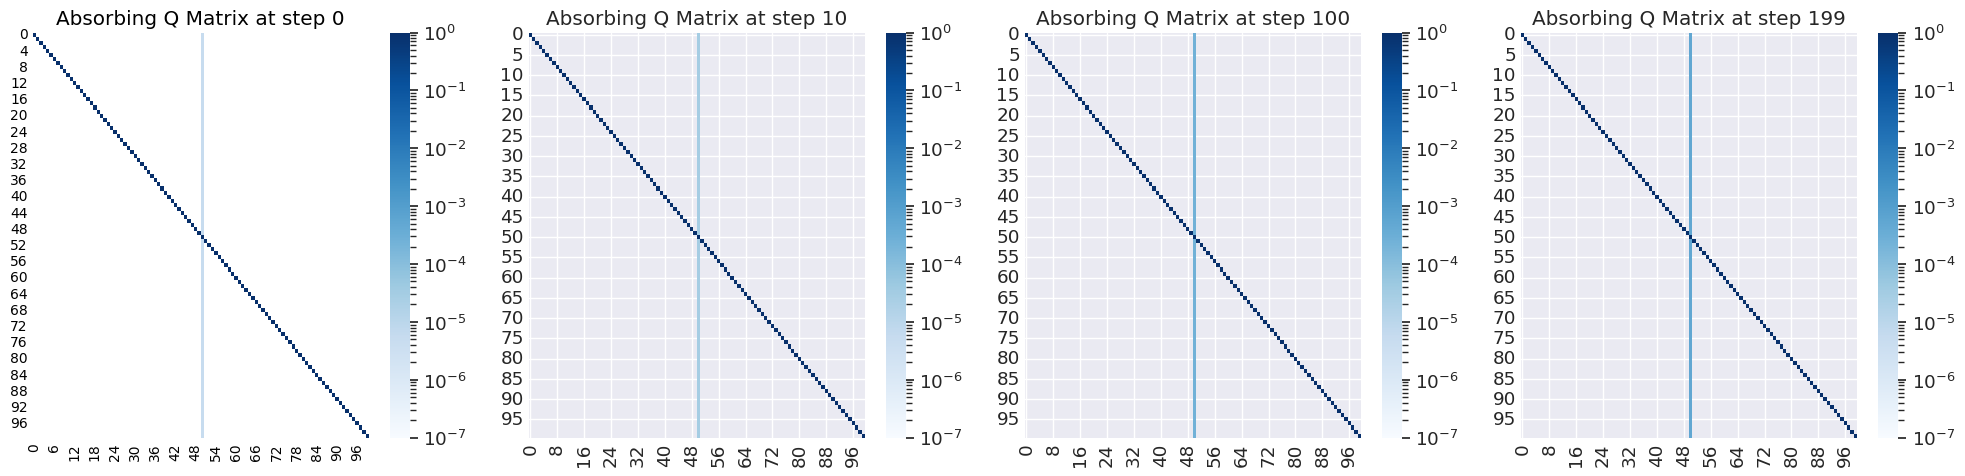

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LogNorm

array_of_matrices =q_one_step_mats[([0,10,100,199])]


plt.figure(figsize=(5*4, 5))
steps = [0,10,100,199]
for i in range(len(array_of_matrices)):
    plt.subplot(1, len(array_of_matrices), i+1)

    sns.set(font_scale=1.2)  # Adjust font scale for better readability
    sns.heatmap(array_of_matrices[i], annot=False, fmt='.1e', cmap="Blues",norm=LogNorm(vmin=1e-7, vmax=1) ,linewidths=0)
    plt.title(f'Absorbing Q Matrix at step {steps[i]}')

    plt.tick_params(axis='both', which='both', length=0)

plt.tight_layout()
plt.show()

Uniform Case

In [12]:
betas = generate_beta_t(np.arange(nb_time_steps))
q_one_step_mats = [make_uniform_mat(t,betas,num_bins)for t in range(0, nb_time_steps)]

q_one_step_mats = np.stack(q_one_step_mats, axis=0)  # Q for all t


Lest's visulatize the q_one_step_mats

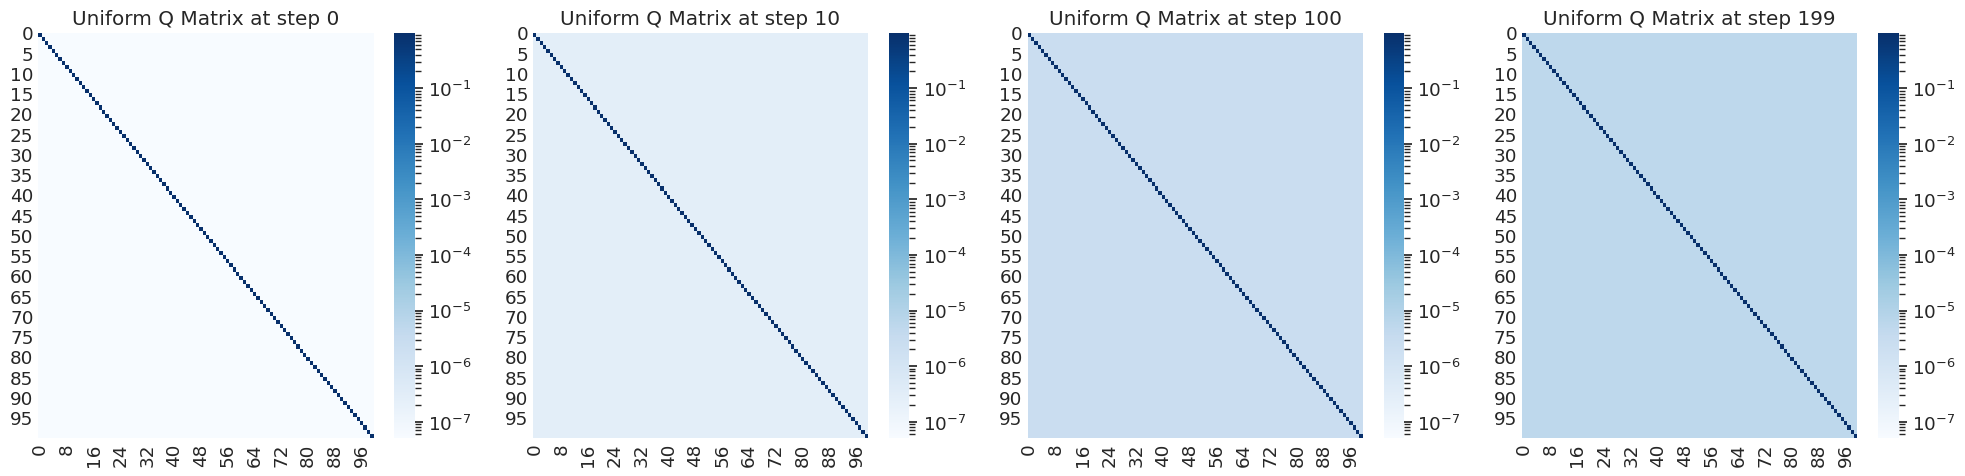

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LogNorm

array_of_matrices =q_one_step_mats[([0,10,100,199])]


plt.figure(figsize=(5*4, 5))
steps = [0,10,100,199]
for i in range(len(array_of_matrices)):
    plt.subplot(1, len(array_of_matrices), i+1)

    sns.set(font_scale=1.2)  # Adjust font scale for better readability
    sns.heatmap(array_of_matrices[i], annot=False, fmt='.1e', cmap="Blues",norm=LogNorm(vmin=array_of_matrices.min(), vmax=array_of_matrices.max()))
    plt.title(f'Uniform Q Matrix at step {steps[i]}')

    plt.tick_params(axis='both', which='both', length=0)

plt.tight_layout()
plt.show()

Now we can perform the forward process as:
$$q({x_t}|x_{t-1}) = Cat(x_t; p=x_{t-1} Q_t)  $$

but what if we need to transition directly from $x_0  to x_t $ ?
well it can be proven that :

$$q({x_t}|x_{0}) = Cat(x_t; p=x_{t-1} \overline{Q_t})  $$

where $ \overline{Q_t} = Q_1Q_2...Q_t $

the following code computes  $ \overline{Q_t}$ for all timesteps and store it in q_mats



In [14]:
q_mat_t = q_one_step_mats[0]

q_mats = [q_mat_t]

for t in range(1, nb_time_steps):
  # Q_{1...t} = Q_{1 ... t-1} Q_t = Q_1 Q_2 ... Q_t
  q_mat_t = np.tensordot(q_mat_t, q_one_step_mats[t],
                          axes=[[1], [0]])
  q_mats.append(q_mat_t)

q_mats = np.stack(q_mats, axis=0)

In [15]:
q_mats.shape  # shape (timesteps , K , K)

(200, 100, 100)

Now we can implement the q_sample function (forward function)

In [16]:
def get_transtion_p( a, t, x):
    """Extract coefficients at specified timesteps t and conditioning data x.

    Args:
      a: torch.Tensor: PyTorch tensor of constants indexed by time.
      t: torch.Tensor: PyTorch tensor of time indices, shape = (batch_size,).
      x: torch.Tensor: PyTorch tensor of shape (bs, ...) of int32 or int64 type.
        (Noisy) data. Should not be of one hot representation, but have integer
        values representing the class values.

    Returns:
      a[t, x]: torch.Tensor: PyTorch tensor.
    """
    t_broadcast =  t = t.view(*([-1] + [1] * (x.dim() - 1)))

    return a[t_broadcast, x.long()]


def get_transtion_p_onehot( a, t, x):
    """Extract coefficients at specified timesteps t and conditioning data x.

    Args:
      a: torch.Tensor: PyTorch tensor of constants indexed by time.
      t: torch.Tensor: PyTorch tensor of time indices, shape = (bs,).
      x: torch.Tensor: PyTorch tensor, shape (bs, ..., num_pixel_vals), float32 type.
        (Noisy) data. Should be of one-hot-type representation.

    Returns:
      out: torch.Tensor: PyTorch tensor. Output of torch.matmul(x, a[t, None, None, ...]).
        Shape = (bs, ..., num_pixel_vals)
    """
    ret = torch.matmul(x, torch.from_numpy(a[t, ...]).float())
    # print("on hot at",ret , x ,a[t, ...] )
    return torch.matmul(x, torch.from_numpy(a[t, ...]).float())

def q_sample( x_start, t, noise):
    """Sample from q(x_t | x_start) (i.e. add noise to the data).

    Args:
      x_start: torch.Tensor: original clean data, in integer form (not onehot).
        shape = (bs, ...).
      t: torch.Tensor: timestep of the diffusion process, shape (bs,).
      noise: torch.Tensor: uniform noise on [0, 1) used to sample noisy data.
        Should be of shape (*x_start.shape, num_pixel_vals).

    Returns:
      sample: torch.Tensor: same shape as x_start. noisy data.
    """
    assert noise.shape == x_start.shape + (num_bins,)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')



    ttt = get_transtion_p(q_mats, t.cpu(), x_start.cpu())

    xx = torch.tensor( ttt  ).to(device)

    logits = torch.log( xx+ (eps) ).to(device)


    # To avoid numerical issues clip the noise to a minimum value
    noise = torch.clamp(noise, min=eps, max=1.).to(device)

    gumbel_noise = - torch.log(-torch.log(noise)).to(device)  # noise for sampling

    return torch.argmax(logits + gumbel_noise, dim=-1).to(device)

Let's have a faster corrupting schedule for visulaization

In [17]:
def generate_beta_t_2(array_t, beta_0=0.001, beta_T=0.04):
    """
    Returns the beta_t values for each time step.
    It's a cosine interpolation from beta_0 to beta_T.
    """
    steps = (
            np.arange(len(array_t) + 1, dtype=np.float64) /
            len(array_t))
    alpha_bar = np.cos((steps + 0.008) / 1.008 * np.pi / 2)
    betas = np.minimum(1 - alpha_bar[1:] / alpha_bar[:-1], 0.999)


    return torch.tensor(betas)

In [18]:
betas = generate_beta_t_2(np.arange(nb_time_steps))
q_one_step_mats = [make_uniform_mat(t,betas,num_bins)for t in range(0, nb_time_steps)]

q_one_step_mats = np.stack(q_one_step_mats, axis=0)

q_mat_t = q_one_step_mats[0]

q_mats = [q_mat_t]

for t in range(1, nb_time_steps):
  # Q_{1...t} = Q_{1 ... t-1} Q_t = Q_1 Q_2 ... Q_t
  q_mat_t = np.tensordot(q_mat_t, q_one_step_mats[t],
                          axes=[[1], [0]])
  q_mats.append(q_mat_t)

q_mats = np.stack(q_mats, axis=0)

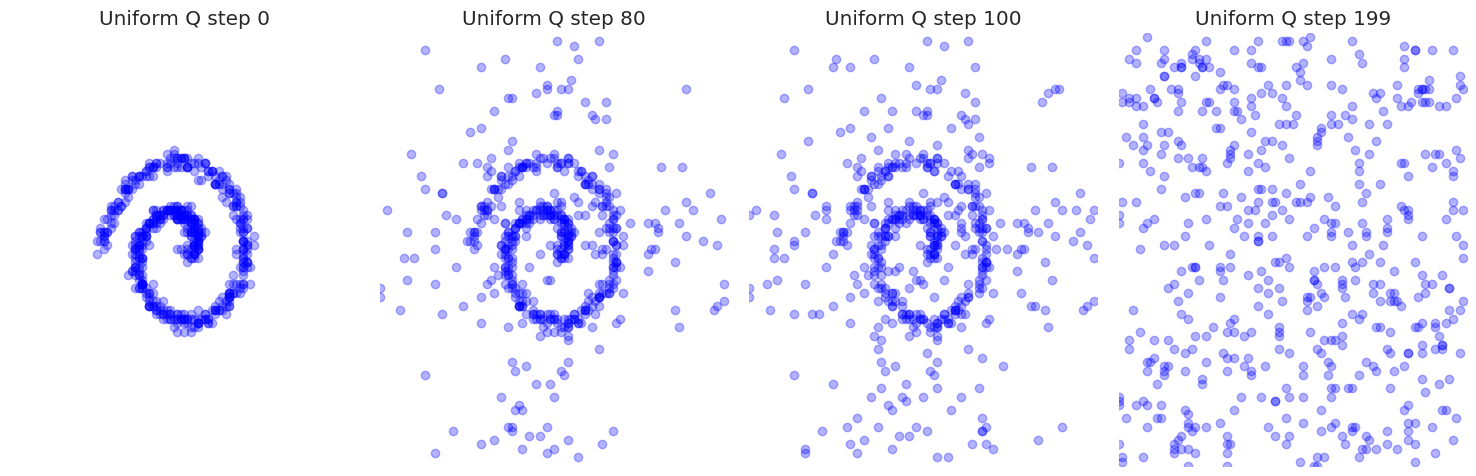

In [20]:
data = torch.tensor(spiral_dataset(True))

noise = torch.rand( *data.shape,num_bins)

ts = [80,100,199]

fig, axes = plt.subplots(1, len(ts)+1, figsize=(15, 5))  # Adjust figsize as needed



axes[0].scatter(data[:, 0], data[:, 1], color='blue', alpha=0.3)  # Use any colormap you prefer
axes[0].set_title(f'Uniform Q step 0')
axes[0].axis('off')
axes[0].set_xlim(0, 100)
axes[0].set_ylim(0, 100)
for i in range(len(ts)):
    X  = q_sample(data, torch.tensor([ts[i]]*data.shape[0]), noise).cpu()
    x = X[:, 0]
    y = X[:, 1]
    axes[i+1].scatter(x, y, color='blue', alpha=0.3)  # Use any colormap you prefer
    axes[i+1].set_title(f'Uniform Q step {ts[i]}')
    axes[i+1].axis('off')
    axes[i + 1].set_xlim(0, 100)
    axes[i + 1].set_ylim(0, 100)


plt.tight_layout()
plt.show()


**switch** to Absorbing

In [21]:
betas = generate_beta_t_2(np.arange(nb_time_steps))
q_one_step_mats = [make_absorb_mat(t,betas,num_bins)for t in range(0, nb_time_steps)]

q_one_step_mats = np.stack(q_one_step_mats, axis=0)

q_mat_t = q_one_step_mats[0]

q_mats = [q_mat_t]

for t in range(1, nb_time_steps):
  # Q_{1...t} = Q_{1 ... t-1} Q_t = Q_1 Q_2 ... Q_t
  q_mat_t = np.tensordot(q_mat_t, q_one_step_mats[t],
                          axes=[[1], [0]])
  q_mats.append(q_mat_t)

q_mats = np.stack(q_mats, axis=0)

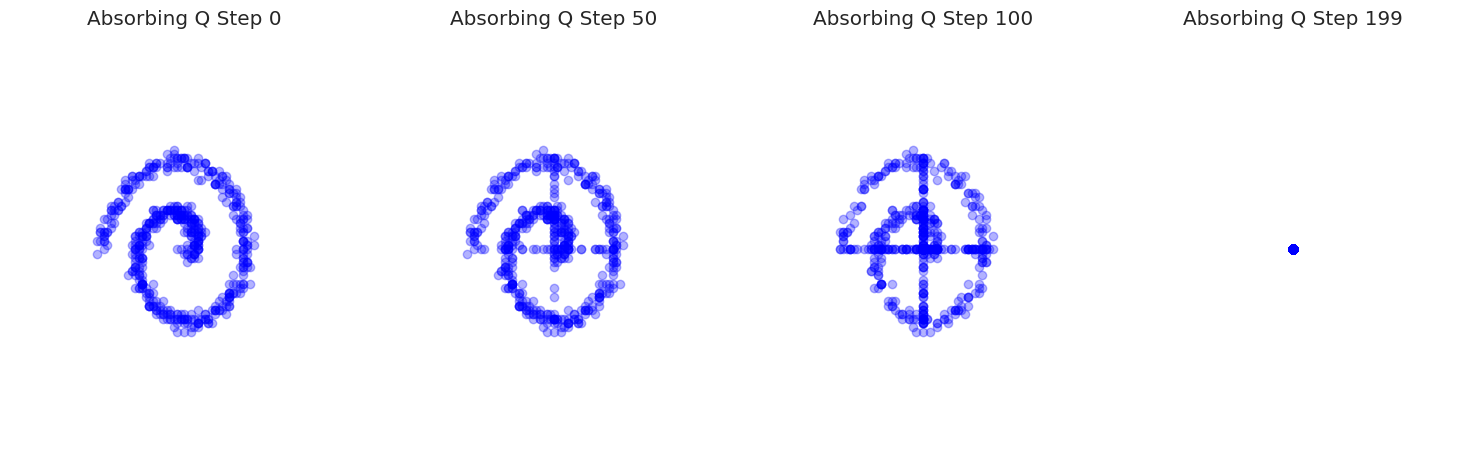

In [22]:
data = torch.tensor(spiral_dataset(True))

noise = torch.rand( *data.shape,num_bins)

ts = [50,100,199]

fig, axes = plt.subplots(1, len(ts)+1, figsize=(15, 5))  # Adjust figsize as needed




axes[0].scatter(data[:, 0], data[:, 1], color='blue', alpha=0.3)  # Use any colormap you prefer
axes[0].set_title(f'Absorbing Q Step 0')
axes[0].axis('off')
axes[0].set_xlim(0, 100)
axes[0].set_ylim(0, 100)
for i in range(len(ts)):
    X  = q_sample(data, torch.tensor([ts[i]]*data.shape[0]), noise).cpu()
    x = X[:, 0]
    y = X[:, 1]
    axes[i+1].scatter(x, y, color='blue', alpha=0.3)  # Use any colormap you prefer
    axes[i+1].set_title(f'Absorbing Q Step {ts[i]}')
    axes[i+1].axis('off')
    axes[i + 1].set_xlim(0, 100)
    axes[i + 1].set_ylim(0, 100)


plt.tight_layout()
plt.show()


The following *q_posterior_logits* function is used to compute $$ q (x_{t-1}|x_t, {x_{0}}) $$

from the equation above we can compute $q (x_{t-1}|x_t, {x_{0}})$ as following:

$$log(q (x_{t-1}|x_t,{x_{0}})) = log(fact1) + log (fact2) $$

fact1 is just $q (x_{t}|x_{t-1}, x_{0}) $ which is equivalent to $ q (x_{t}|x_{t-1})  $ this is becuase of the markov property

and fact2 is just  $q (x_{t-1}| x_{0})$

the denominator is ignored as it's just a normalizing factor


>Reintialize the Q matrices to uniform transition

In [23]:
betas = generate_beta_t(np.arange(nb_time_steps))
q_one_step_mats = [make_uniform_mat(t,betas,num_bins)for t in range(0, nb_time_steps)]

q_one_step_mats = np.stack(q_one_step_mats, axis=0)

q_mat_t = q_one_step_mats[0]

q_mats = [q_mat_t]

for t in range(1, nb_time_steps):
  # Q_{1...t} = Q_{1 ... t-1} Q_t = Q_1 Q_2 ... Q_t
  q_mat_t = np.tensordot(q_mat_t, q_one_step_mats[t],
                          axes=[[1], [0]])
  q_mats.append(q_mat_t)

q_mats = np.stack(q_mats, axis=0)

In [24]:
transpose_q_onestep_mats = np.transpose(q_one_step_mats,axes=(0, 2, 1))

def q_posterior_logits(x_start, x_t, t, x_start_logits):
    """Compute logits of q(x_{t-1} | x_t, x_start)."""
    tm = x_t.shape + (num_bins,)


    if x_start_logits:
        assert x_start.shape == x_t.shape + (num_bins,)
    else:
        assert x_start.shape == x_t.shape


    fact1 = get_transtion_p(transpose_q_onestep_mats, t, x_t.cpu())

    # print("fact1 ",fact1, "qpost  soft", torch.nn.functional.softmax(x_start, dim=-1))


    if x_start_logits:
        fact2 = get_transtion_p_onehot(q_mats, t-1,
                                torch.nn.functional.softmax(x_start, dim=-1).cpu())

        tzero_logits = x_start
    else:
        fact2 = get_transtion_p(q_mats, t-1, x_start.cpu())

        tzero_logits = torch.log(
            torch.nn.functional.one_hot(x_start.long(), num_classes=num_bins)
            + eps)

    out = torch.log( ( torch.tensor(fact1) + (eps)) ) + torch.log( (torch.tensor(fact2) + eps) )
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    t_broadcast =  t.view(*([-1] + [1] * (out.ndim - 1))).to(device)


    ret = torch.where(t_broadcast == 0, tzero_logits.to(device), out.to(device))  # in case of step 0 just return the predicted logits of X0



    return ret

Now using eqn(1)  we can compute $P_{\theta} (x_{t-1}| x_{t})$

since the model just x0 rather than distribution we can ignore the expectation

the following function computes it



In [25]:

def p_logits( x, t):
  """
      Compute logits of p(x_{t-1} | x_t).
      Args:
        t: torch.Tensor: PyTorch tensor of time indices, shape = (batch_size,).
        x: torch.Tensor: PyTorch tensor of shape (bs, ...) of int32 or int64 type.
          (Noisy) data.
  """


  pred_x_start_logits  = model(x.to(device).float(), t.unsqueeze(1).float().to(device))

  t_broadcast  = t.view(*([-1] + [1] * (pred_x_start_logits.ndim - 1))).to(device)

  tmp = q_posterior_logits(pred_x_start_logits.to(device), x.to(device),
                                                    t, x_start_logits=True)


  model_logits = torch.where(t_broadcast == 0,
                            pred_x_start_logits.to(device),
                            tmp.to(device)
                            )  # in case of step 0 just return the predicted logits of X0

  assert (model_logits.shape ==
        pred_x_start_logits.shape == x.shape + (num_bins,))

  return model_logits, pred_x_start_logits

#**Loss Computation**

loss is parmaterized as follows:
$$
Loss =  L_{vb}  + λ E_{q(x_0)}E_{q(x_t|x_0)}[-log (\tilde{P_{\theta}} (\tilde{x_{0}}| x_{t}))]
$$




Let's first take the term $L_{vb}$
it is just a variational upper bound loss of diffusion model same as the continuous case ie. :

$$
E_{q(x0)} [  D_{kl} [q (x_{T}| {x_{0}}) || P(x_{T})] + \sum_{t=2}^{T} D_{kl} [q (x_{t-1},x_t| {x_{0}}) || P_{\theta} (x_{t-1}| x_{t}) ] - E_{q(x0)}E_{q(x_t|x_0)}[log p_{\theta}(x_0|x_t)] ]
]$$

eqn(2)

which is based on the idea In order to optimize the generative model pθ(x0) to fit the data distribution q(x0), we typically
optimize a variational upper bound on the negative log-likelihood:





>First let's implement $L_{vb}$ using the function vb_terms_bpd().
we can ignore the first term as it's always guaranteed, what we can do is we can compute $ D_{kl} [q (x_{t-1},x_t| {x_{0}}) || P_{\theta} (x_{t-1}| x_{t})] $ whenever the t != 0 and compute the log-likelihood in case of t =0, when talking about kl divergence where measuring how different two distributions are from each other. by adding this to the loss we are shifting the prediction distribution towards the data distribution. the following code was heavily inspired by the base implementation





In [26]:
def meanflat(x):
      return x.mean(dim = tuple(range(1, len(x.shape))))

def categorical_kl_logits(logits1, logits2, eps=1e-3):
    """KL divergence between categorical distributions.

    Distributions parameterized by logits.

    Args:
        logits1: logits of the first distribution. Last dim is class dim.
        logits2: logits of the second distribution. Last dim is class dim.
        eps: float small number to avoid numerical issues.

    Returns:
        KL(C(logits1) || C(logits2)): shape: logits1.shape[:-1]
    """


    softmax1 = torch.nn.functional.softmax(logits1 + eps, dim=-1)

    log_softmax1 = torch.nn.functional.log_softmax(logits1 + eps, dim=-1)
    log_softmax2 = torch.nn.functional.log_softmax(logits2 + eps, dim=-1)


    out = softmax1 * (log_softmax1 - log_softmax2)
    return torch.sum(out, dim=-1)


def categorical_log_likelihood(x, logits):
      """Log likelihood of a discretized Gaussian specialized for image data.

      Assumes data `x` consists of integers [0, num_classes-1].

      Args:
        x: where to evaluate the distribution. shape = (bs, ...), dtype=int32/int64
        logits: logits, shape = (bs, ..., num_classes)

      Returns:
        log likelihoods
      """
      log_probs = torch.nn.functional.log_softmax(logits, dim=-1)
      x_onehot = torch.nn.functional.one_hot(x.long(), logits.shape[-1]).to(logits.dtype)
      return torch.sum(log_probs * x_onehot, dim=-1)



def vb_terms_bpd(x_start, x_t, t):
  """Calculate specified terms of the variational bound.

  Args:
    model_fn: the denoising network
    x_start: original clean data
    x_t: noisy data
    t: timestep of the noisy data (and the corresponding term of the bound
      to return)

  Returns:
    a pair `(kl, pred_start_logits)`, where `kl` are the requested bound terms
    (specified by `t`), and `pred_x_start_logits` is logits of
    the denoised image.
  """
  true_logits =  q_posterior_logits(x_start, x_t, t, x_start_logits=False).to(device)
  model_logits, pred_x_start_logits = p_logits( x=x_t, t=t)

  kl = categorical_kl_logits(logits1=true_logits.to(device), logits2=model_logits.to(device))
  assert kl.shape == x_start.shape
  kl = meanflat(kl) / np.log(2.)


  decoder_nll = -categorical_log_likelihood(x_start.to(device), model_logits.to(device))
  assert decoder_nll.shape == x_start.shape
  decoder_nll = meanflat(decoder_nll) / np.log(2.)

  assert kl.shape == decoder_nll.shape == t.shape == (x_start.shape[0],)
  return torch.where(t.to(device) == 0, decoder_nll.to(device), kl.to(device)), pred_x_start_logits.to(device)



# Second term of loss
Now the second part of the loss, we basically want to minimize the expectation $E_{q(x0)}E_{q(x_t|x_0)}[-log (\tilde{P_{\theta}} (\tilde{x_{0}}| x_{t}))]$
Note that we have expectations because the transition process itself is probabilistic and we want to minimize the expectation of negative log liklihood i.e. maximize the likelihood that the model outputs the true $x_0$

\

Increase the likelihood probability of the model outputting the true $x_0$ which can also be minimized if we took the cross entropy loss between $\tilde{P_{\theta}} (\tilde{x_{0}}| x_{t})$ and the true $X_0$
as that's equivalent to minimizing the negative log likelihood


as
$$-log(\tilde{P_{\theta}} (\tilde{x_{0}}| x_{t})) = - \sum x_{0}^ilog(\tilde{x_{0}}^i) = \sum H(x_{0}^i, \tilde{x_{0}}^i)$$







In [27]:
def cross_entropy_x_start(x_start, pred_x_start_logits):
  """Calculate crossentropy between x_start and predicted x_start.

  Args:
    x_start: original clean data
    pred_x_start_logits: predicted_logits

  Returns:
    ce: cross entropy.
  """

  ce = -categorical_log_likelihood(x_start, pred_x_start_logits)
  assert ce.shape == x_start.shape
  ce = meanflat(ce) / np.log(2.)

  assert ce.shape == (x_start.shape[0],)

  return ce

Finally we can combine everything into the training_step function

In [28]:
def training_step(x_start):

    """   full training step """

    noise = torch.rand(*x_start.shape, num_bins)

    t = torch.randint(0, nb_time_steps, (x_start.shape[0],), dtype=torch.int32)


    x_t =q_sample(x_start=x_start, t=t, noise=noise)


    vb_losses, pred_x_start_logits = vb_terms_bpd(
                x_start=x_start, x_t=x_t, t=t)

    ce_losses = cross_entropy_x_start(
    x_start=x_start, pred_x_start_logits=pred_x_start_logits)


    losses = vb_losses +  0.1 * ce_losses  # o.1 is just a hyperpramater


    assert losses.shape == t.shape

    losses  = torch.sum(losses)


    return losses


> Now let's train, the following is a simple torch training loop

In [29]:
def set_global_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Set a global seed
set_global_seed(42)


from tqdm import tqdm  # Import tqdm for the progress bar

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = MLP(num_bins= num_bins).to(device)


num_epochs = 500
dataloader = DataLoader(
        spiral_dataset(), batch_size=228, shuffle=True, drop_last=True)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')



for epoch in range(num_epochs):
      with tqdm(dataloader, desc=f'Epoch {epoch+1}/{num_epochs}', dynamic_ncols=True) as t:

        for batch_data in dataloader:
            # Zero the gradients
            optimizer.zero_grad()
            batch_data = batch_data[0].to(device)

            # Forward pass
            loss = training_step((batch_data.float().to(device)))

            # Backward pass
            loss.backward()

            # Update the weights
            optimizer.step()


            t.update(1)
            t.set_postfix(loss=loss.item())

Epoch 1/500:   0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-24-8d76b461db61>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  out = torch.log( ( torch.tensor(fact1) + (eps)) ) + torch.log( (torch.tensor(fact2) + eps) )
Epoch 500/500: 100%|██████████| 2/2 [00:00<00:00, 26.14it/s, loss=3.35]


>Let's see the *result* by sampling new data

In [30]:
def sample_time_step( x, t, noise):
      """Sample one timestep from the model p(x_{t-1} | x_t)."""

      model_logits, pred_x_start_logits = p_logits(
           x=x, t=t)

      assert noise.shape == model_logits.shape, noise.shape

      # No noise when t == 0
      nonzero_mask = (t != 0).to(x.dtype).reshape(x.shape[0],  *([1] * (len(x.shape))))


      # For numerical precision clip the noise to a minimum value
      noise = torch.clamp(noise, min=eps, max=1.)
      gumbel_noise = -torch.log(-torch.log(noise))

      sample = torch.argmax(model_logits.to(device) + nonzero_mask.to(device) * gumbel_noise.to(device), dim=-1)

      assert sample.shape == x.shape
      assert pred_x_start_logits.shape == model_logits.shape
      return sample, torch.nn.functional.softmax(pred_x_start_logits, dim=-1)


In [31]:
def sample( no_samples, rng ,transtion_absorbing=False):
  """ sampling."""

  # torch.manual_seed(rng)
  init_rng, body_rng = torch.chunk(torch.tensor([rng,rng]), 2)
  del rng

  shape = (no_samples,2)

  noise_shape = shape + (num_bins,)

  def body_fun(i, x):
      t = torch.full([shape[0]], nb_time_steps - 1 - i, dtype=torch.int32)
      x, _ = sample_time_step(
          x=x,
          t=t,
          noise=torch.rand(noise_shape)
      )
      return x.cpu()



  x_init = torch.randint(0, num_bins, size=shape)

  if transtion_absorbing:

    x_init = torch.full(shape, fill_value=num_bins // 2, dtype=torch.int32) # if we are using absorbing transition X_T is just the absorbing state



  final_x = x_init

  steps = [x_init]
  sts= [0,70, 100,160,180 ,190,195,197]
  for i in range(nb_time_steps):
      final_x = body_fun(i, final_x)
      if i in sts:
        steps.append(final_x)

  steps.append(final_x)

  return final_x , steps

In [32]:
_ , Xs = sample(1200,42)    # Xs is multiple Xt at diffrent time steps

<ipython-input-24-8d76b461db61>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  out = torch.log( ( torch.tensor(fact1) + (eps)) ) + torch.log( (torch.tensor(fact2) + eps) )


Lets Plot the sampling process

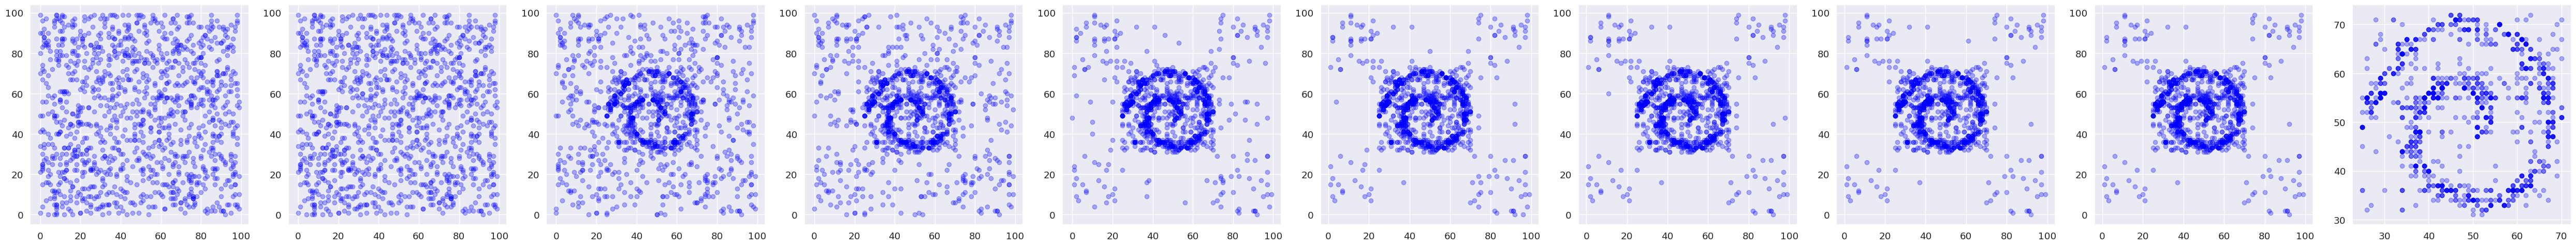

In [33]:
import matplotlib.pyplot as plt
import numpy as np

# Sample data for demonstration
num_plots = len(Xs)  # Number of scatter plots
data = [np.random.rand(50) for _ in range(num_plots)]  # Generate random data for each plot

# Create individual scatter plots
plt.figure(figsize=(num_plots*5, 5))

for i in range(num_plots):
    x = Xs[i][:, 0]
    y = Xs[i][:, 1]
    plt.subplot(1, num_plots, i+1)  # 1 row, 'num_plots' columns, position 'i+1'
    plt.scatter(x, y, color='blue', alpha=0.3)
    plt.title(f'')

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

##Now let's train another model on the Absorbing transition **case**

let's redifine Q

In [ ]:

betas = generate_beta_t(np.arange(nb_time_steps))
q_one_step_mats = [make_absorb_mat(t,betas,num_bins)for t in range(0, nb_time_steps)]

q_one_step_mats = np.stack(q_one_step_mats, axis=0)

q_mat_t = q_one_step_mats[0]

q_mats = [q_mat_t]

for t in range(1, nb_time_steps):
  # Q_{1...t} = Q_{1 ... t-1} Q_t = Q_1 Q_2 ... Q_t
  q_mat_t = np.tensordot(q_mat_t, q_one_step_mats[t],
                          axes=[[1], [0]])
  q_mats.append(q_mat_t)

q_mats = np.stack(q_mats, axis=0)

transpose_q_onestep_mats = np.transpose(q_one_step_mats,axes=(0, 2, 1))


In [ ]:
def set_global_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Set a global seed
set_global_seed(42)


from tqdm import tqdm  # Import tqdm for the progress bar

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = MLP(num_bins= num_bins).to(device)


num_epochs = 500
dataloader = DataLoader(
        spiral_dataset(), batch_size=228, shuffle=True, drop_last=True)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')



for epoch in range(num_epochs):
      with tqdm(dataloader, desc=f'Epoch {epoch+1}/{num_epochs}', dynamic_ncols=True) as t:

        for batch_data in dataloader:
            # Zero the gradients
            optimizer.zero_grad()
            batch_data = batch_data[0].to(device)

            # Forward pass
            loss = training_step((batch_data.float().to(device)))


            # Backward pass
            loss.backward()

            # Update the weights
            optimizer.step()


            t.update(1)
            t.set_postfix(loss=loss.item())

Epoch 1/500:   0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-68-83227a5cd775>:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  out = torch.log( ( torch.tensor(fact1) + (eps)) ) + torch.log( (torch.tensor(fact2) + eps) )
Epoch 500/500: 100%|██████████| 2/2 [00:00<00:00, 16.88it/s, loss=2.27]


In [ ]:
_ , Xs = sample(1200,42, True)

<ipython-input-68-83227a5cd775>:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  out = torch.log( ( torch.tensor(fact1) + (eps)) ) + torch.log( (torch.tensor(fact2) + eps) )


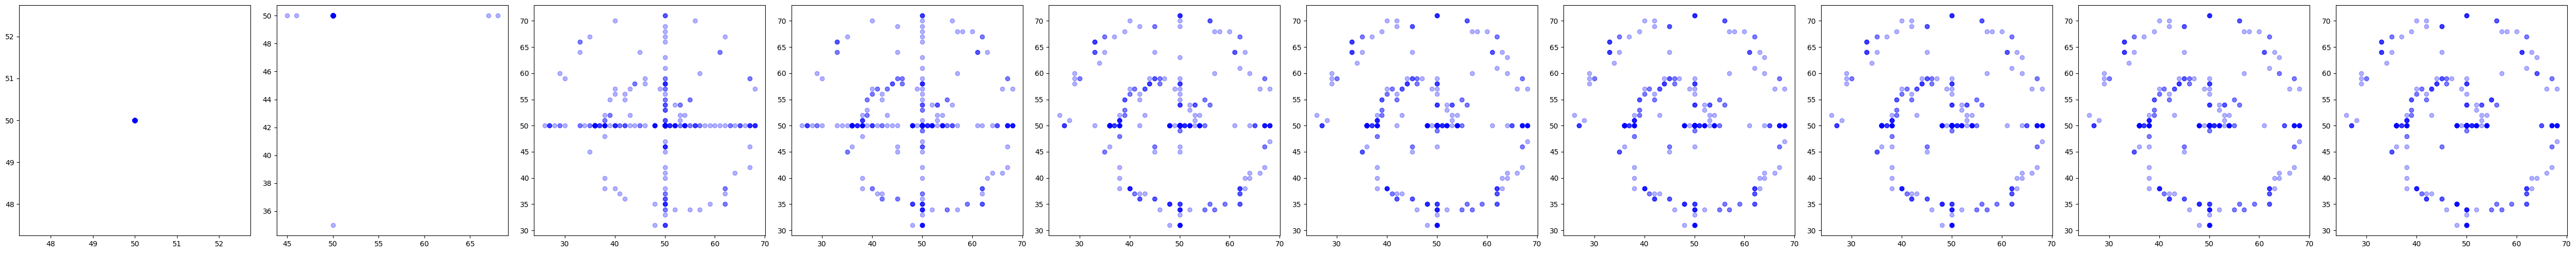

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Sample data for demonstration
num_plots = len(Xs)  # Number of scatter plots
data = [np.random.rand(50) for _ in range(num_plots)]  # Generate random data for each plot

# Create individual scatter plots
plt.figure(figsize=(num_plots*5, 5))

for i in range(num_plots):
    x = Xs[i][:, 0]
    y = Xs[i][:, 1]
    plt.subplot(1, num_plots, i+1)  # 1 row, 'num_plots' columns, position 'i+1'
    plt.scatter(x, y, color='blue', alpha=0.3)
    plt.title(f'')

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

#**Second Section (Image generation)**

Basic Unet model

Inspired from [link](https://github.com/egafni/AI/blob/792bd2b627b26e5cd4b8f013bc948336583eebaa/ai/diffusion/diffusion_utilities.py#L11)

In [3]:

class ResidualConvBlock(nn.Module):
    def __init__(
        self, in_channels: int, out_channels: int, is_res: bool = False
    ) -> None:
        super().__init__()

        # Check if input and output channels are the same for the residual connection
        self.same_channels = in_channels == out_channels

        # Flag for whether or not to use residual connection
        self.is_res = is_res

        # First convolutional layer
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1),   # 3x3 kernel with stride 1 and padding 1
            nn.BatchNorm2d(out_channels),   # Batch normalization
            nn.GELU(),   # GELU activation function
        )

        # Second convolutional layer
        self.conv2 = nn.Sequential(
            nn.Conv2d(out_channels, out_channels, 3, 1, 1),   # 3x3 kernel with stride 1 and padding 1
            nn.BatchNorm2d(out_channels),   # Batch normalization
            nn.GELU(),   # GELU activation function
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:

        # If using residual connection
        if self.is_res:
            # Apply first convolutional layer
            x1 = self.conv1(x)

            # Apply second convolutional layer
            x2 = self.conv2(x1)

            # If input and output channels are the same, add residual connection directly
            if self.same_channels:
                out = x + x2
            else:
                # If not, apply a 1x1 convolutional layer to match dimensions before adding residual connection
                shortcut = nn.Conv2d(x.shape[1], x2.shape[1], kernel_size=1, stride=1, padding=0).to(x.device)
                out = shortcut(x) + x2
            #print(f"resconv forward: x {x.shape}, x1 {x1.shape}, x2 {x2.shape}, out {out.shape}")

            # Normalize output tensor
            return out / 1.414

        # If not using residual connection, return output of second convolutional layer
        else:
            x1 = self.conv1(x)
            x2 = self.conv2(x1)
            return x2

    # Method to get the number of output channels for this block
    def get_out_channels(self):
        return self.conv2[0].out_channels

    # Method to set the number of output channels for this block
    def set_out_channels(self, out_channels):
        self.conv1[0].out_channels = out_channels
        self.conv2[0].in_channels = out_channels
        self.conv2[0].out_channels = out_channels



class UnetUp(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UnetUp, self).__init__()

        # Create a list of layers for the upsampling block
        # The block consists of a ConvTranspose2d layer for upsampling, followed by two ResidualConvBlock layers
        layers = [
            nn.ConvTranspose2d(in_channels, out_channels, 2, 2),
            ResidualConvBlock(out_channels, out_channels),
            ResidualConvBlock(out_channels, out_channels),
        ]

        # Use the layers to create a sequential model
        self.model = nn.Sequential(*layers)

    def forward(self, x, skip):
        # Concatenate the input tensor x with the skip connection tensor along the channel dimension
        x = torch.cat((x, skip), 1)

        # Pass the concatenated tensor through the sequential model and return the output
        x = self.model(x)
        return x


class UnetDown(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UnetDown, self).__init__()

        # Create a list of layers for the downsampling block
        # Each block consists of two ResidualConvBlock layers, followed by a MaxPool2d layer for downsampling
        layers = [ResidualConvBlock(in_channels, out_channels), ResidualConvBlock(out_channels, out_channels), nn.MaxPool2d(2)]

        # Use the layers to create a sequential model
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        # Pass the input through the sequential model and return the output
        return self.model(x)

class EmbedFC(nn.Module):
    def __init__(self, input_dim, emb_dim):
        super(EmbedFC, self).__init__()
        '''
        This class defines a generic one layer feed-forward neural network for embedding input data of
        dimensionality input_dim to an embedding space of dimensionality emb_dim.
        '''
        self.input_dim = input_dim

        # define the layers for the network
        layers = [
            nn.Linear(input_dim, emb_dim),
            nn.GELU(),
            nn.Linear(emb_dim, emb_dim),
        ]

        # create a PyTorch sequential model consisting of the defined layers
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        # flatten the input tensor
        x = x.view(-1, self.input_dim)
        # apply the model layers to the flattened tensor
        return self.model(x)


transform = transforms.Compose([
    transforms.ToTensor(),                # from [0,255] to range [0.0,1.0]
    transforms.Normalize((0.5,), (0.5,))  # range [-1,1]

])
class ContextUnet(nn.Module):
    def __init__(self, in_channels, n_feat=256, n_cfeat=10, height=28, nb_class=3):  # cfeat - context features
        super(ContextUnet, self).__init__()

        # number of input channels, number of intermediate feature maps and number of classes
        self.in_channels = in_channels
        self.n_feat = n_feat
        self.n_cfeat = n_cfeat
        self.h = height  #assume h == w. must be divisible by 4, so 28,24,20,16...
        self.nb_class = nb_class

        # Initialize the initial convolutional layer
        self.embedding = nn.Embedding(self.nb_class, in_channels)
        self.init_conv = ResidualConvBlock(in_channels, n_feat, is_res=True)

        # Initialize the down-sampling path of the U-Net with two levels
        self.down1 = UnetDown(n_feat, n_feat)        # down1 #[10, 256, 8, 8]
        self.down2 = UnetDown(n_feat, 2 * n_feat)    # down2 #[10, 256, 4,  4]

         # original: self.to_vec = nn.Sequential(nn.AvgPool2d(7), nn.GELU())
        self.to_vec = nn.Sequential(nn.AvgPool2d((4)), nn.GELU())

        # Embed the timestep and context labels with a one-layer fully connected neural network
        self.timeembed1 = EmbedFC(1, 2*n_feat)
        self.timeembed2 = EmbedFC(1, 1*n_feat)
        self.contextembed1 = EmbedFC(n_cfeat, 2*n_feat)
        self.contextembed2 = EmbedFC(n_cfeat, 1*n_feat)

        # Initialize the up-sampling path of the U-Net with three levels
        self.up0 = nn.Sequential(
            nn.ConvTranspose2d(2 * n_feat, 2 * n_feat, self.h//4, self.h//4), # up-sample
            nn.GroupNorm(8, 2 * n_feat), # normalize
            nn.ReLU(),
        )
        self.up1 = UnetUp(4 * n_feat, n_feat)
        self.up2 = UnetUp(2 * n_feat, n_feat)

        # Initialize the final convolutional layers to map to the same number of channels as the input image
        self.out = nn.Sequential(
            nn.Conv2d(2 * n_feat, n_feat, 3, 1, 1), # reduce number of feature maps   #in_channels, out_channels, kernel_size, stride=1, padding=0
            nn.GroupNorm(8, n_feat), # normalize
            nn.ReLU(),
            nn.Conv2d(n_feat, nb_class, 3, 1, 1), # map to same number of channels as input
        )

    def forward(self, x, t, c=None):
        """
        x : (batch, n_feat, h, w) : input image
        t : (batch, n_cfeat)      : time step
        c : (batch, n_classes)    : context label
        """
        # x is the input image, c is the context label, t is the timestep, context_mask says which samples to block the context on

        # pass the input image through the initial convolutional layer
        x = x.permute(0, 2, 3, 1).long().squeeze(-1) # permute to (batch, h, w, n_feat)
        x = self.embedding(x)
        x = x.permute(0, 3, 1, 2).float()
        x = self.init_conv(x)
        # pass the result through the down-sampling path
        down1 = self.down1(x)       #[10, 256, 8, 8]
        down2 = self.down2(down1)   #[10, 256, 4, 4]

        # convert the feature maps to a vector and apply an activation
        hiddenvec = self.to_vec(down2)

        # mask out context if context_mask == 1
        if c is None:
            c = torch.zeros(x.shape[0], self.n_cfeat).to(x)

        # embed context and timestep
        cemb1 = self.contextembed1(c).view(-1, self.n_feat * 2, 1, 1)     # (batch, 2*n_feat, 1,1)
        temb1 = self.timeembed1(t).view(-1, self.n_feat * 2, 1, 1)
        cemb2 = self.contextembed2(c).view(-1, self.n_feat, 1, 1)
        temb2 = self.timeembed2(t).view(-1, self.n_feat, 1, 1)
        #print(f"uunet forward: cemb1 {cemb1.shape}. temb1 {temb1.shape}, cemb2 {cemb2.shape}. temb2 {temb2.shape}")


        up1 = self.up0(hiddenvec)
        up2 = self.up1(cemb1*up1 + temb1, down2)  # add and multiply embeddings
        up3 = self.up2(cemb2*up2 + temb2, down1)
        out = self.out(torch.cat((up3, x), 1))
        return out

In [4]:
# @title Data loader and noise Schedule

import torch
import torchvision
import torchvision.transforms as transforms

# import dataset class from torch
from torch.utils.data import Dataset

import numpy as np

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


def generate_beta_t(array_t, beta_0=0.001, beta_T=0.04):
    """
    Returns the beta_t values for each time step.
    It's a cosine interpolation from beta_0 to beta_T.
    """
    steps = (
            np.arange(len(array_t) + 1, dtype=np.float64) /
            len(array_t))
    alpha_bar = np.cos((steps + 0.008) / 1.008 * np.pi / 2)
    betas = np.minimum(1 - alpha_bar[1:] / alpha_bar[:-1], 0.999)


    return betas

class DiscretizeMnist(Dataset):
    """
    Simple dataset that discretizes the MNIST dataset.
    """

    def __init__(self, num_bins=10):
        """
        Args:
            data (torch.Tensor): data to be discretized
            labels (torch.Tensor): labels for the data
            num_bins (int): number of bins to discretize the data into
        """
        # get the data and labels
        self.num_bins = num_bins

        # import classic mnist dataset
        self.mnist = torchvision.datasets.MNIST(
            root="./data", train=True, download=True
        )

        self.transform = transforms.Compose(
            [transforms.ToTensor()]
        )

    def __len__(self):
        return len(self.mnist)

    def __getitem__(self, idx):
        """
        Returns a tuple of (discretized data, label)
        """
        # get the data and label
        data, label = self.mnist[idx]

        # transform the data
        data = self.transform(data)

        # discretize the data
        data = self.discretize(data)

        return data, label

    def discretize(self, data):
        """
        Discretizes the data into self.num_bins bins.
        """
        # get the min and max of the data
        min_val = torch.min(data)
        max_val = torch.max(data)

        # get the bin size
        bin_size = (max_val - min_val) / self.num_bins

        # discretize the data
        data = torch.floor((data - min_val) / bin_size)

        # max being num_bins - 1
        data = torch.clamp(data, 0, self.num_bins - 1)

        return data






# The Trainer Class


The Trainer Class: Combining Functionality for Enhanced Parameter Flexibility
Below is the Trainer class, which consolidates all the functions detailed in the preceding section. This encapsulation facilitates seamless parameter adjustments such as transition type, number of bins, and more.



In [21]:
# @title Main Model
# @markdown   Contains loss defination, forward function ....



class MnistTrainer():
    """
    Trainer module for the MNIST model.
    """

    def __init__(self,hybrid_coeff= 0.0001, hidden_dim=128, num_bins=4, nb_time_steps=254, transitionType = 'absorbing' ,   path = None):
        """
        Args:
            hidden_dim (int): hidden dimension of the model
            num_bins (int): number of bins to discretize the data into
            nb_block (int): number of blocks in the model
        """
        super().__init__()

        self.hidden_dim = hidden_dim
        self.num_bins = num_bins
        self.num_pixel_vals = num_bins

        self.nb_time_steps = nb_time_steps
        self.num_timesteps = nb_time_steps


        self.betas = generate_beta_t(np.arange(nb_time_steps))

        self.eps = 1.e-6
        self.hybrid_coeff = hybrid_coeff
        self.counter =0

        self.transitionType = transitionType

        self.make_transition_matrix(transitionType)

        # create the model
        self.model = ContextUnet(in_channels=1, n_feat=hidden_dim, n_cfeat=10, height=28, nb_class=num_bins)

        if path != None :
          state_dict = torch.load(path)
          self.model.load_state_dict(state_dict)

    def make_transition_matrix  (self,transitionType):

        q_one_step_mats = None
        if transitionType == 'absorbing' :
          q_one_step_mats = [self.make_absorb_mat(t) for t in range(0, self.num_timesteps)]

        if transitionType == 'uniform':
          q_one_step_mats = [self.make_uniform_mat(t)for t in range(0, self.num_timesteps)]


        self.q_onestep_mats = np.stack(q_one_step_mats, axis=0)


        q_mat_t = self.q_onestep_mats[0]

        q_mats = [q_mat_t]

        for t in range(1, self.num_timesteps):
          # Q_{1...t} = Q_{1 ... t-1} Q_t = Q_1 Q_2 ... Q_t
          q_mat_t = np.tensordot(q_mat_t, self.q_onestep_mats[t],
                                  axes=[[1], [0]])
          q_mats.append(q_mat_t)

        self.q_mats = np.stack(q_mats, axis=0)


        assert self.q_mats.shape == (self.num_timesteps, self.num_pixel_vals,
                                    self.num_pixel_vals), self.q_mats.shape


        self.transpose_q_onestep_mats = np.transpose(self.q_onestep_mats,
                                                      axes=(0, 2, 1))


    def make_absorb_mat(self, t):
      """Computes transition matrix for q(x_t|x_{t-1}).

     construct a transition Q_t matrix that has an absorbing state for pixelvalues self.num_pixel_vals//2.

      Args:
        t: timestep. integer scalar.

      Returns:
        Q_t: transition matrix. shape = (num_pixel_vals, num_pixel_vals).
      """
      beta_t = self.betas[t]

      diag = np.full(shape=(self.num_pixel_vals,), fill_value=1. - beta_t,
                      dtype=np.float64)
      mat = np.diag(diag, k=0)
      mat[:, self.num_pixel_vals//2] += beta_t

      return mat

    def make_uniform_mat(self, t):
      """Computes transition matrix for q(x_t|x_{t-1}).

      construct a transition Q_t matrix with uniform probability to all other states.

      Args:
        t: timestep. integer scalar.

      Returns:
        Q_t: transition matrix. shape = (num_pixel_vals, num_pixel_vals).
      """
      beta_t = self.betas[t]
      mat = np.full(shape=(self.num_pixel_vals, self.num_pixel_vals),
                    fill_value=beta_t/float(self.num_pixel_vals),
                    dtype=np.float64)
      diag_indices = np.diag_indices_from(mat)
      diag_val = 1. - beta_t * (self.num_pixel_vals-1.)/self.num_pixel_vals
      mat[diag_indices] = diag_val

      return mat

    def q_posterior_logits(self, x_start, x_t, t, x_start_logits):
        """Compute logits of q(x_{t-1} | x_t, x_start)."""
        tm = x_t.shape + (self.num_pixel_vals,)

        if x_start_logits:
            assert x_start.shape == x_t.shape + (self.num_pixel_vals,)
        else:
            assert x_start.shape == x_t.shape


        fact1 = self.get_transtion_p(self.transpose_q_onestep_mats, t, x_t.cpu())

        if x_start_logits:
            fact2 = self.get_transtion_p_onehot(self.q_mats, t-1,
                                    torch.nn.functional.softmax(x_start, dim=-1).cpu())

            tzero_logits = x_start
        else:
            fact2 = self.get_transtion_p(self.q_mats, t-1, x_start.cpu())
            tzero_logits = torch.log(
                torch.nn.functional.one_hot(x_start.long(), num_classes=self.num_pixel_vals)
                + self.eps)


        # At t=0 we need the logits of q(x_{-1}|x_0, x_start)

        ter1 =  ( torch.tensor(fact1) + (self.eps))
        ter2 =  ( fact2) + (self.eps)
        if type(ter2) != torch.Tensor:
          ter2 = torch.tensor(ter2)

        out = torch.log( ter1) + torch.log(ter2)
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

        t_broadcast =  t.view(*([-1] + [1] * (out.ndim - 1))).to(device)


        ret = torch.where(t_broadcast == 0, tzero_logits.to(device), out.to(device))



        return ret
    def get_transtion_p(self, a, t, x):
        """Extract coefficients at specified timesteps t and conditioning data x.

        Args:
          a: torch.Tensor: PyTorch tensor of constants indexed by time.
          t: torch.Tensor: PyTorch tensor of time indices, shape = (batch_size,).
          x: torch.Tensor: PyTorch tensor of shape (bs, ...) of int32 or int64 type.
            (Noisy) data. Should not be of one hot representation, but have integer
            values representing the class values.

        Returns:
          a[t, x]: torch.Tensor: PyTorch tensor.
        """
        t_broadcast =  t = t.view(*([-1] + [1] * (x.dim() - 1)))

        return a[t_broadcast, x.long()]


    def get_transtion_p_onehot(self, a, t, x):
        """Extract coefficients at specified timesteps t and conditioning data x.

        Args:
          a: torch.Tensor: PyTorch tensor of constants indexed by time.
          t: torch.Tensor: PyTorch tensor of time indices, shape = (bs,).
          x: torch.Tensor: PyTorch tensor, shape (bs, ..., num_pixel_vals), float32 type.
            (Noisy) data. Should be of one-hot-type representation.

        Returns:
          out: torch.Tensor: PyTorch tensor. Output of torch.matmul(x, a[t, None, None, ...]).
            Shape = (bs, ..., num_pixel_vals)
        """
        return torch.matmul(x, torch.from_numpy(a[t, None, None, ...]).float())


    def categorical_log_likelihood(self,x, logits):
      """Log likelihood of a discretized Gaussian specialized for image data.

      Assumes data `x` consists of integers [0, num_classes-1].

      Args:
        x: where to evaluate the distribution. shape = (bs, ...), dtype=int32/int64
        logits: logits, shape = (bs, ..., num_classes)

      Returns:
        log likelihoods
      """
      log_probs = torch.nn.functional.log_softmax(logits, dim=-1)
      x_onehot = torch.nn.functional.one_hot(x.long(), logits.shape[-1]).to(logits.dtype)
      return torch.sum(log_probs * x_onehot, dim=-1)


    def meanflat(self,x):
        return x.mean(dim = tuple(range(1, len(x.shape))))
    def vb_terms_bpd(self, *, x_start, x_t, t):
      """Calculate specified terms of the variational bound.

      Args:
        model_fn: the denoising network
        x_start: original clean data
        x_t: noisy data
        t: timestep of the noisy data (and the corresponding term of the bound
          to return)

      Returns:
        a pair `(kl, pred_start_logits)`, where `kl` are the requested bound terms
        (specified by `t`), and `pred_x_start_logits` is logits of
        the denoised image.
      """
      true_logits = self.q_posterior_logits(x_start, x_t, t, x_start_logits=False).to(device)
      model_logits, pred_x_start_logits = self.p_logits( x=x_t, t=t)

      kl = self.categorical_kl_logits(logits1=true_logits.to(device), logits2=model_logits.to(device))
      assert kl.shape == x_start.shape
      kl = self.meanflat(kl) / np.log(2.)

      decoder_nll = -self.categorical_log_likelihood(x_start.to(device), model_logits.to(device))
      assert decoder_nll.shape == x_start.shape
      decoder_nll = self.meanflat(decoder_nll) / np.log(2.)

      # At the first timestep return the decoder NLL,
      # otherwise return KL(q(x_{t-1}|x_t,x_start) || p(x_{t-1}|x_t))
      assert kl.shape == decoder_nll.shape == t.shape == (x_start.shape[0],)
      return torch.where(t.to(device) == 0, decoder_nll.to(device), kl.to(device)), pred_x_start_logits.to(device)
      # torch.where(t_broadcast == 0, tzero_logits, out)



    def categorical_kl_logits(self,logits1, logits2, eps=1e-6):
        """KL divergence between categorical distributions.

        Distributions parameterized by logits.

        Args:
            logits1: logits of the first distribution. Last dim is class dim.
            logits2: logits of the second distribution. Last dim is class dim.
            eps: float small number to avoid numerical issues.

        Returns:
            KL(C(logits1) || C(logits2)): shape: logits1.shape[:-1]
        """
        softmax1 = torch.nn.functional.softmax(logits1 + eps, dim=-1)
        log_softmax1 = torch.nn.functional.log_softmax(logits1 + eps, dim=-1)
        log_softmax2 = torch.nn.functional.log_softmax(logits2 + eps, dim=-1)

        out = softmax1 * (log_softmax1 - log_softmax2)
        return torch.sum(out, dim=-1)

    def cross_entropy_x_start(self, x_start, pred_x_start_logits):
      """Calculate crossentropy between x_start and predicted x_start.

      Args:
        x_start: original clean data
        pred_x_start_logits: predicted_logits

      Returns:
        ce: cross entropy.
      """

      ce = -self.categorical_log_likelihood(x_start, pred_x_start_logits)
      assert ce.shape == x_start.shape
      ce = self.meanflat(ce) / np.log(2.)

      assert ce.shape == (x_start.shape[0],)

      return ce




    def training_step(self, batch, _):
        """
        Training step.
        """
        # get the data and label
        # data, data_next, _, init_data, time_step = batch
        x_start, _ = batch

        noise_rng, time_rng = torch.chunk(torch.rand(2), 2)
        noise = torch.rand(*x_start.shape, self.num_pixel_vals)
        t = torch.randint(0, self.num_timesteps, (x_start.shape[0],), dtype=torch.int32)

        # t starts at zero. so x_0 is the first noisy datapoint, not the datapoint
        # itself.
        x_t = self.q_sample(x_start=x_start, t=t, noise=noise)


        vb_losses, pred_x_start_logits = self.vb_terms_bpd(
                   x_start=x_start, x_t=x_t, t=t)

        ce_losses = self.cross_entropy_x_start(
        x_start=x_start, pred_x_start_logits=pred_x_start_logits)

        losses = vb_losses + self.hybrid_coeff * ce_losses


        assert losses.shape == t.shape

        losses  = torch.sum(losses)

        if self.counter % 100 ==0:
          print(losses)
        self.counter+=1


        return losses

    # on training end
    def on_train_epoch_end(self):
        # we should generate some images
        with torch.no_grad():
            self.generate()

    def q_probs(self, x_start, t):
      """Compute probabilities of q(x_t | x_start).

      Args:
        x_start: jnp.ndarray: jax array of shape (bs, ...) of int32 or int64 type.
          Should not be of one hot representation, but have integer values
          representing the class values.
        t: jnp.ndarray: jax array of shape (bs,).

      Returns:
        probs: jnp.ndarray: jax array, shape (bs, x_start.shape[1:],
                                              num_pixel_vals).
    """
      return self.get_transtion_p(self.q_mats, t, x_start)

    def q_sample(self, x_start, t, noise):
        """Sample from q(x_t | x_start) (i.e. add noise to the data).

        Args:
          x_start: torch.Tensor: original clean data, in integer form (not onehot).
            shape = (bs, ...).
          t: torch.Tensor: timestep of the diffusion process, shape (bs,).
          noise: torch.Tensor: uniform noise on [0, 1) used to sample noisy data.
            Should be of shape (*x_start.shape, num_pixel_vals).

        Returns:
          sample: torch.Tensor: same shape as x_start. noisy data.
        """
        assert noise.shape == x_start.shape + (self.num_pixel_vals,)
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')



        xx = torch.tensor( self.q_probs(x_start.cpu(), t.cpu()) ).to(device)

        logits = torch.log( xx+ (self.eps) ).to(device)


        # To avoid numerical issues clip the noise to a minimum value
        noise = torch.clamp(noise, min=self.eps, max=1.).to(device)

        gumbel_noise = - torch.log(-torch.log(noise)).to(device)

        return torch.argmax(logits + gumbel_noise, dim=-1).to(device)

    def p_logits(self, *, x, t):
      device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
      self.model.to(device)


      pred_x_start_logits  = self.model(x.to(device), t.unsqueeze(1).float().to(device)).permute(0, 2, 3, 1).unsqueeze(1)


      t_broadcast  = t.view(*([-1] + [1] * (pred_x_start_logits.ndim - 1))).to(device)

      tmp = self.q_posterior_logits(pred_x_start_logits.to(device), x.to(device),
                                                        t, x_start_logits=True)

      model_logits = torch.where(t_broadcast == 0,
                                pred_x_start_logits.to(device),
                                tmp.to(device)
                                )



      assert (model_logits.shape ==
            pred_x_start_logits.shape == x.shape + (self.num_pixel_vals,))

      return model_logits, pred_x_start_logits

    def sample_time_step(self, x, t, noise):
      """Sample one timestep from the model p(x_{t-1} | x_t)."""

      model_logits, pred_x_start_logits = self.p_logits(
           x=x, t=t)
      assert noise.shape == model_logits.shape, noise.shape

      # No noise when t == 0
      nonzero_mask = (t != 0).to(x.dtype).reshape(x.shape[0],  *([1] * (len(x.shape))))



      # For numerical precision clip the noise to a minimum value
      noise = torch.clamp(noise, min=self.eps, max=1.)
      gumbel_noise = -torch.log(-torch.log(noise))

      sample = torch.argmax(model_logits.to(device) + nonzero_mask.to(device) * gumbel_noise.to(device), dim=-1)

      assert sample.shape == x.shape
      assert pred_x_start_logits.shape == model_logits.shape
      return sample, torch.nn.functional.softmax(pred_x_start_logits, dim=-1)


    def sample(self, rng):
      """ sampling."""

      shape = (1, 28, 28)

      # torch.manual_seed(rng)
      init_rng, body_rng = torch.chunk(torch.tensor([rng,rng]), 2)
      del rng

      noise_shape = shape + (self.num_pixel_vals,)

      def body_fun(i, x):
          t = torch.full([shape[0]], self.num_timesteps - 1 - i, dtype=torch.int32)
          x, _ = self.sample_time_step(
              x=x,
              t=t,
              noise=torch.rand(noise_shape).unsqueeze(0)
          )
          return x.cpu()


      x_init = None
      if self.transitionType == 'absorbing':
         x_init = torch.full(shape, fill_value=self.num_pixel_vals // 2, dtype=torch.int32).unsqueeze(0)

      else:
         x_init = torch.randint(0, self.num_pixel_vals, size=shape).unsqueeze(0)





      del init_rng

      num_timesteps = self.num_timesteps




      final_x = x_init

      steps = [final_x]

      self.save_image(final_x, -1)
      sts= [0,20,60,90,120,125,126, 150,180,190,196,198]


      for i in range(num_timesteps):
          final_x = body_fun(i, final_x)
          if i in sts:
             self.save_image(final_x, i)
             steps.append(final_x)

      steps.append(final_x)
      return final_x,steps

    def generate(self):
        """
        Method to generate some images.
        """

        data,_ = self.sample(23)

        self.save_image(data, self.nb_time_steps)




    def save_image(self, data, i):
        """
        Saves the image.
        """
        # plot the data
        plt.imshow(data.squeeze().cpu().numpy(), cmap="gray")

        # title
        plt.title(f"data = {i}")

        # save the figure
        plt.savefig(f"data_{i}.png")

        # close the figure
        plt.close()


# Training

#First let's start with Uniform

In [22]:
# @title Training
num_hidden_dim = 8 # @param {type:"number"}
num_bins = 3 # @param {type:"integer"}
diffusion_steps = 127 # @param {type:"integer"}
transition_type = "uniform" # @param ["uniform", "absorbing"]
num_epochs = 20 # @param {type:"integer"}
batch_size = 120 # @param {type:"integer"}

dataset = DiscretizeMnist(num_bins=3)

loader = torch.utils.data.DataLoader(
    dataset, batch_size=batch_size, num_workers=8, shuffle=True
)

# now we create the model
model = MnistTrainer(hybrid_coeff =0.0001 ,hidden_dim=num_hidden_dim, num_bins=num_bins, nb_time_steps=diffusion_steps,transitionType = transition_type)

optimizer = torch.optim.Adam(model.model.parameters(), lr=0.01)

def set_global_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Set a global seed
set_global_seed(42312)


for epoch in range(num_epochs):
    # model.train()  # Set the model to training mode
    with tqdm(loader, desc=f'Epoch {epoch+1}/{num_epochs}', dynamic_ncols=True) as t:

      for batch_data, batch_labels in loader:
          # Zero the gradients
          optimizer.zero_grad()

          # Forward pass
          loss = model.training_step((batch_data.to(device),batch_labels),None)


          # Backward pass
          loss.backward()

          # Update the weights
          optimizer.step()


          t.update(1)
          t.set_postfix(loss=loss.item())

      if epoch %3==0:
        model.on_train_epoch_end()


Epoch 1/20:   0%|          | 2/500 [00:00<06:43,  1.24it/s, loss=1.07]

tensor(1.3766, device='cuda:0', dtype=torch.float64, grad_fn=<SumBackward0>)


Epoch 1/20:  21%|██        | 103/500 [00:09<00:29, 13.51it/s, loss=0.314]

tensor(1.6945, device='cuda:0', dtype=torch.float64, grad_fn=<SumBackward0>)


Epoch 1/20:  40%|████      | 202/500 [00:17<00:30,  9.84it/s, loss=0.355]

tensor(0.2791, device='cuda:0', dtype=torch.float64, grad_fn=<SumBackward0>)


Epoch 1/20:  61%|██████    | 303/500 [00:25<00:15, 12.93it/s, loss=0.349]

tensor(0.3844, device='cuda:0', dtype=torch.float64, grad_fn=<SumBackward0>)


Epoch 1/20:  81%|████████  | 403/500 [00:33<00:07, 13.66it/s, loss=0.248]

tensor(0.2692, device='cuda:0', dtype=torch.float64, grad_fn=<SumBackward0>)


Epoch 2/20:   0%|          | 2/500 [00:00<06:49,  1.22it/s, loss=0.237]

tensor(0.2135, device='cuda:0', dtype=torch.float64, grad_fn=<SumBackward0>)


Epoch 2/20:  20%|██        | 102/500 [00:08<00:33, 11.78it/s, loss=0.234]

tensor(0.2167, device='cuda:0', dtype=torch.float64, grad_fn=<SumBackward0>)


Epoch 2/20:  41%|████      | 203/500 [00:16<00:24, 12.21it/s, loss=0.194]

tensor(0.2124, device='cuda:0', dtype=torch.float64, grad_fn=<SumBackward0>)


Epoch 2/20:  61%|██████    | 303/500 [00:25<00:14, 13.45it/s, loss=0.2]  

tensor(0.1923, device='cuda:0', dtype=torch.float64, grad_fn=<SumBackward0>)


Epoch 2/20:  81%|████████  | 403/500 [00:33<00:06, 13.92it/s, loss=0.203]

tensor(0.1987, device='cuda:0', dtype=torch.float64, grad_fn=<SumBackward0>)


Epoch 3/20:   1%|          | 3/500 [00:00<02:15,  3.66it/s, loss=0.215]

tensor(0.2045, device='cuda:0', dtype=torch.float64, grad_fn=<SumBackward0>)


Epoch 3/20:  21%|██        | 103/500 [00:09<00:31, 12.70it/s, loss=0.197]

tensor(0.1889, device='cuda:0', dtype=torch.float64, grad_fn=<SumBackward0>)


Epoch 3/20:  41%|████      | 203/500 [00:16<00:21, 13.50it/s, loss=0.215]

tensor(0.1877, device='cuda:0', dtype=torch.float64, grad_fn=<SumBackward0>)


Epoch 3/20:  61%|██████    | 303/500 [00:25<00:14, 13.48it/s, loss=0.198]

tensor(0.2096, device='cuda:0', dtype=torch.float64, grad_fn=<SumBackward0>)


Epoch 3/20:  80%|████████  | 402/500 [00:33<00:10,  9.73it/s, loss=0.191]

tensor(0.1994, device='cuda:0', dtype=torch.float64, grad_fn=<SumBackward0>)


Epoch 4/20:   1%|          | 3/500 [00:00<02:12,  3.75it/s, loss=0.189]

tensor(0.1862, device='cuda:0', dtype=torch.float64, grad_fn=<SumBackward0>)


Epoch 4/20:  21%|██        | 103/500 [00:09<00:29, 13.41it/s, loss=0.227]

tensor(0.2485, device='cuda:0', dtype=torch.float64, grad_fn=<SumBackward0>)


Epoch 4/20:  40%|████      | 202/500 [00:17<00:31,  9.56it/s, loss=0.2]  

tensor(0.1864, device='cuda:0', dtype=torch.float64, grad_fn=<SumBackward0>)


Epoch 4/20:  61%|██████    | 303/500 [00:24<00:14, 13.58it/s, loss=0.193]

tensor(0.1939, device='cuda:0', dtype=torch.float64, grad_fn=<SumBackward0>)


Epoch 4/20:  81%|████████  | 403/500 [00:34<00:07, 13.08it/s, loss=0.191]

tensor(0.1864, device='cuda:0', dtype=torch.float64, grad_fn=<SumBackward0>)


Epoch 5/20:   0%|          | 2/500 [00:00<06:43,  1.24it/s, loss=0.194]

tensor(0.1824, device='cuda:0', dtype=torch.float64, grad_fn=<SumBackward0>)


Epoch 5/20:  20%|██        | 102/500 [00:08<00:35, 11.06it/s, loss=0.195]

tensor(0.1892, device='cuda:0', dtype=torch.float64, grad_fn=<SumBackward0>)


Epoch 5/20:  40%|████      | 202/500 [00:18<00:45,  6.60it/s, loss=0.191]

tensor(0.1976, device='cuda:0', dtype=torch.float64, grad_fn=<SumBackward0>)


Epoch 5/20:  61%|██████    | 303/500 [00:30<00:14, 13.37it/s, loss=0.193]

tensor(0.2103, device='cuda:0', dtype=torch.float64, grad_fn=<SumBackward0>)


Epoch 5/20:  81%|████████  | 403/500 [00:42<00:07, 13.51it/s, loss=0.195]

tensor(0.1860, device='cuda:0', dtype=torch.float64, grad_fn=<SumBackward0>)


Epoch 6/20:   0%|          | 1/500 [00:01<08:39,  1.04s/it, loss=0.199]

tensor(0.1995, device='cuda:0', dtype=torch.float64, grad_fn=<SumBackward0>)


Epoch 6/20:  21%|██        | 103/500 [00:13<00:39, 10.00it/s, loss=0.187]

tensor(0.1848, device='cuda:0', dtype=torch.float64, grad_fn=<SumBackward0>)


Epoch 6/20:  41%|████      | 203/500 [00:25<00:27, 10.81it/s, loss=0.175]

tensor(0.1972, device='cuda:0', dtype=torch.float64, grad_fn=<SumBackward0>)


Epoch 6/20:  60%|██████    | 302/500 [00:35<00:27,  7.25it/s, loss=0.195]

tensor(0.1885, device='cuda:0', dtype=torch.float64, grad_fn=<SumBackward0>)


Epoch 6/20:  81%|████████  | 403/500 [00:45<00:07, 12.70it/s, loss=0.184]

tensor(0.1907, device='cuda:0', dtype=torch.float64, grad_fn=<SumBackward0>)


Epoch 7/20:   0%|          | 2/500 [00:01<04:44,  1.75it/s, loss=0.176]

tensor(0.1748, device='cuda:0', dtype=torch.float64, grad_fn=<SumBackward0>)


Epoch 7/20:  21%|██        | 103/500 [00:09<00:28, 13.74it/s, loss=0.181]

tensor(0.1949, device='cuda:0', dtype=torch.float64, grad_fn=<SumBackward0>)


Epoch 7/20:  41%|████      | 203/500 [00:17<00:23, 12.78it/s, loss=0.195]

tensor(0.2007, device='cuda:0', dtype=torch.float64, grad_fn=<SumBackward0>)


Epoch 7/20:  60%|██████    | 301/500 [00:28<00:35,  5.64it/s, loss=0.188]

tensor(0.1877, device='cuda:0', dtype=torch.float64, grad_fn=<SumBackward0>)


Epoch 7/20:  80%|████████  | 402/500 [00:38<00:09, 10.49it/s, loss=0.178]

tensor(0.1826, device='cuda:0', dtype=torch.float64, grad_fn=<SumBackward0>)


Epoch 8/20:   0%|          | 2/500 [00:00<06:42,  1.24it/s, loss=0.194]

tensor(0.1844, device='cuda:0', dtype=torch.float64, grad_fn=<SumBackward0>)


Epoch 8/20:  21%|██        | 103/500 [00:09<00:29, 13.69it/s, loss=0.19] 

tensor(0.1821, device='cuda:0', dtype=torch.float64, grad_fn=<SumBackward0>)


Epoch 8/20:  41%|████      | 203/500 [00:18<00:23, 12.82it/s, loss=0.188]

tensor(0.1903, device='cuda:0', dtype=torch.float64, grad_fn=<SumBackward0>)


Epoch 8/20:  61%|██████    | 303/500 [00:25<00:14, 13.51it/s, loss=0.186]

tensor(0.1858, device='cuda:0', dtype=torch.float64, grad_fn=<SumBackward0>)


Epoch 8/20:  81%|████████  | 403/500 [00:34<00:07, 13.46it/s, loss=0.189]

tensor(0.1797, device='cuda:0', dtype=torch.float64, grad_fn=<SumBackward0>)


Epoch 9/20:   1%|          | 3/500 [00:00<02:08,  3.87it/s, loss=0.18] 

tensor(0.1958, device='cuda:0', dtype=torch.float64, grad_fn=<SumBackward0>)


Epoch 9/20:  20%|██        | 101/500 [00:11<01:25,  4.65it/s, loss=0.178]

tensor(0.1776, device='cuda:0', dtype=torch.float64, grad_fn=<SumBackward0>)


Epoch 9/20:  41%|████      | 203/500 [00:21<00:21, 13.56it/s, loss=0.184]

tensor(0.1776, device='cuda:0', dtype=torch.float64, grad_fn=<SumBackward0>)


Epoch 9/20:  61%|██████    | 303/500 [00:30<00:14, 13.53it/s, loss=0.175]

tensor(0.1854, device='cuda:0', dtype=torch.float64, grad_fn=<SumBackward0>)


Epoch 9/20:  81%|████████  | 403/500 [00:38<00:07, 12.83it/s, loss=0.193]

tensor(0.1834, device='cuda:0', dtype=torch.float64, grad_fn=<SumBackward0>)


Epoch 10/20:   1%|          | 3/500 [00:00<02:09,  3.83it/s, loss=0.194]

tensor(0.1827, device='cuda:0', dtype=torch.float64, grad_fn=<SumBackward0>)


Epoch 10/20:  21%|██        | 103/500 [00:10<00:29, 13.53it/s, loss=0.18] 

tensor(0.1874, device='cuda:0', dtype=torch.float64, grad_fn=<SumBackward0>)


Epoch 10/20:  40%|████      | 202/500 [00:19<00:35,  8.29it/s, loss=0.168]

tensor(0.1828, device='cuda:0', dtype=torch.float64, grad_fn=<SumBackward0>)


Epoch 10/20:  60%|██████    | 302/500 [00:27<00:16, 11.97it/s, loss=0.181]

tensor(0.1850, device='cuda:0', dtype=torch.float64, grad_fn=<SumBackward0>)


Epoch 10/20:  81%|████████  | 403/500 [00:35<00:07, 13.06it/s, loss=0.188]

tensor(0.1767, device='cuda:0', dtype=torch.float64, grad_fn=<SumBackward0>)


Epoch 11/20:   0%|          | 2/500 [00:00<03:18,  2.51it/s, loss=0.184]

tensor(0.1842, device='cuda:0', dtype=torch.float64, grad_fn=<SumBackward0>)


Epoch 11/20:  21%|██        | 103/500 [00:09<00:33, 11.76it/s, loss=0.182]

tensor(0.1854, device='cuda:0', dtype=torch.float64, grad_fn=<SumBackward0>)


Epoch 11/20:  41%|████      | 203/500 [00:16<00:23, 12.85it/s, loss=0.188]

tensor(0.1955, device='cuda:0', dtype=torch.float64, grad_fn=<SumBackward0>)


Epoch 11/20:  61%|██████    | 303/500 [00:25<00:14, 13.68it/s, loss=0.183]

tensor(0.1732, device='cuda:0', dtype=torch.float64, grad_fn=<SumBackward0>)


Epoch 11/20:  81%|████████  | 403/500 [00:34<00:08, 10.91it/s, loss=0.165]

tensor(0.2241, device='cuda:0', dtype=torch.float64, grad_fn=<SumBackward0>)


Epoch 12/20:   1%|          | 3/500 [00:00<02:13,  3.71it/s, loss=0.169]

tensor(0.1680, device='cuda:0', dtype=torch.float64, grad_fn=<SumBackward0>)


Epoch 12/20:  21%|██        | 103/500 [00:09<00:30, 12.94it/s, loss=0.185]

tensor(0.1651, device='cuda:0', dtype=torch.float64, grad_fn=<SumBackward0>)


Epoch 12/20:  41%|████      | 203/500 [00:17<00:25, 11.64it/s, loss=0.175]

tensor(0.1761, device='cuda:0', dtype=torch.float64, grad_fn=<SumBackward0>)


Epoch 12/20:  60%|██████    | 302/500 [00:25<00:24,  8.16it/s, loss=0.163]

tensor(0.1774, device='cuda:0', dtype=torch.float64, grad_fn=<SumBackward0>)


Epoch 12/20:  80%|████████  | 402/500 [00:39<00:09, 10.01it/s, loss=0.18] 

tensor(0.1694, device='cuda:0', dtype=torch.float64, grad_fn=<SumBackward0>)


Epoch 13/20:   1%|          | 3/500 [00:00<02:14,  3.70it/s, loss=0.189]

tensor(0.1743, device='cuda:0', dtype=torch.float64, grad_fn=<SumBackward0>)


Epoch 13/20:  21%|██        | 103/500 [00:10<00:31, 12.41it/s, loss=0.175]

tensor(0.1796, device='cuda:0', dtype=torch.float64, grad_fn=<SumBackward0>)


Epoch 13/20:  41%|████      | 203/500 [00:19<00:25, 11.75it/s, loss=0.176]

tensor(0.1740, device='cuda:0', dtype=torch.float64, grad_fn=<SumBackward0>)


Epoch 13/20:  60%|██████    | 302/500 [00:29<00:19, 10.22it/s, loss=0.168]

tensor(0.1634, device='cuda:0', dtype=torch.float64, grad_fn=<SumBackward0>)


Epoch 13/20:  81%|████████  | 403/500 [00:37<00:07, 13.04it/s, loss=0.188]

tensor(0.1742, device='cuda:0', dtype=torch.float64, grad_fn=<SumBackward0>)


Epoch 14/20:   0%|          | 2/500 [00:00<06:38,  1.25it/s, loss=0.164]

tensor(0.1816, device='cuda:0', dtype=torch.float64, grad_fn=<SumBackward0>)


Epoch 14/20:  21%|██        | 103/500 [00:09<00:29, 13.32it/s, loss=0.185]

tensor(0.1840, device='cuda:0', dtype=torch.float64, grad_fn=<SumBackward0>)


Epoch 14/20:  41%|████      | 203/500 [00:16<00:22, 13.25it/s, loss=0.183]

tensor(0.1813, device='cuda:0', dtype=torch.float64, grad_fn=<SumBackward0>)


Epoch 14/20:  60%|██████    | 302/500 [00:25<00:17, 11.60it/s, loss=0.172]

tensor(0.1798, device='cuda:0', dtype=torch.float64, grad_fn=<SumBackward0>)


Epoch 14/20:  81%|████████  | 403/500 [00:35<00:07, 13.50it/s, loss=0.177]

tensor(0.1833, device='cuda:0', dtype=torch.float64, grad_fn=<SumBackward0>)


Epoch 15/20:   0%|          | 2/500 [00:01<04:46,  1.74it/s, loss=0.168]

tensor(0.1797, device='cuda:0', dtype=torch.float64, grad_fn=<SumBackward0>)


Epoch 15/20:  21%|██        | 103/500 [00:09<00:30, 13.13it/s, loss=0.163]

tensor(0.1933, device='cuda:0', dtype=torch.float64, grad_fn=<SumBackward0>)


Epoch 15/20:  40%|████      | 201/500 [00:22<00:41,  7.23it/s, loss=0.185]

tensor(0.1845, device='cuda:0', dtype=torch.float64, grad_fn=<SumBackward0>)


Epoch 15/20:  61%|██████    | 303/500 [00:37<00:21,  9.34it/s, loss=0.198]

tensor(0.1720, device='cuda:0', dtype=torch.float64, grad_fn=<SumBackward0>)


Epoch 15/20:  81%|████████  | 403/500 [00:45<00:07, 13.54it/s, loss=0.185]

tensor(0.1729, device='cuda:0', dtype=torch.float64, grad_fn=<SumBackward0>)


Epoch 16/20:   1%|          | 3/500 [00:00<02:11,  3.78it/s, loss=0.167]

tensor(0.1846, device='cuda:0', dtype=torch.float64, grad_fn=<SumBackward0>)


Epoch 16/20:  20%|██        | 102/500 [00:08<00:35, 11.25it/s, loss=0.207]

tensor(0.1725, device='cuda:0', dtype=torch.float64, grad_fn=<SumBackward0>)


Epoch 16/20:  41%|████      | 203/500 [00:16<00:22, 13.19it/s, loss=0.178]

tensor(0.1778, device='cuda:0', dtype=torch.float64, grad_fn=<SumBackward0>)


Epoch 16/20:  61%|██████    | 303/500 [00:26<00:16, 11.88it/s, loss=0.168]

tensor(0.1970, device='cuda:0', dtype=torch.float64, grad_fn=<SumBackward0>)


Epoch 16/20:  80%|████████  | 402/500 [00:34<00:10,  9.23it/s, loss=0.184]

tensor(0.1774, device='cuda:0', dtype=torch.float64, grad_fn=<SumBackward0>)


Epoch 17/20:   0%|          | 1/500 [00:00<06:24,  1.30it/s, loss=0.169]

tensor(0.1689, device='cuda:0', dtype=torch.float64, grad_fn=<SumBackward0>)


Epoch 17/20:  21%|██        | 103/500 [00:09<00:29, 13.44it/s, loss=0.161]

tensor(0.1851, device='cuda:0', dtype=torch.float64, grad_fn=<SumBackward0>)


Epoch 17/20:  41%|████      | 203/500 [00:17<00:22, 13.25it/s, loss=0.162]

tensor(0.1839, device='cuda:0', dtype=torch.float64, grad_fn=<SumBackward0>)


Epoch 17/20:  60%|██████    | 302/500 [00:25<00:15, 13.11it/s, loss=0.199]

tensor(0.1678, device='cuda:0', dtype=torch.float64, grad_fn=<SumBackward0>)


Epoch 17/20:  81%|████████  | 403/500 [00:35<00:07, 13.32it/s, loss=0.175]

tensor(0.1879, device='cuda:0', dtype=torch.float64, grad_fn=<SumBackward0>)


Epoch 18/20:   0%|          | 2/500 [00:00<03:13,  2.58it/s, loss=0.176]

tensor(0.1871, device='cuda:0', dtype=torch.float64, grad_fn=<SumBackward0>)


Epoch 18/20:  20%|██        | 102/500 [00:12<00:42,  9.40it/s, loss=0.175]

tensor(0.1847, device='cuda:0', dtype=torch.float64, grad_fn=<SumBackward0>)


Epoch 18/20:  40%|████      | 202/500 [00:23<00:32,  9.15it/s, loss=0.18]

tensor(0.1701, device='cuda:0', dtype=torch.float64, grad_fn=<SumBackward0>)


Epoch 18/20:  61%|██████    | 303/500 [00:30<00:14, 13.67it/s, loss=0.168]

tensor(0.1720, device='cuda:0', dtype=torch.float64, grad_fn=<SumBackward0>)


Epoch 18/20:  81%|████████  | 403/500 [00:38<00:07, 13.68it/s, loss=0.178]

tensor(0.1709, device='cuda:0', dtype=torch.float64, grad_fn=<SumBackward0>)


Epoch 19/20:   0%|          | 2/500 [00:01<04:54,  1.69it/s, loss=0.172]

tensor(0.1634, device='cuda:0', dtype=torch.float64, grad_fn=<SumBackward0>)


Epoch 19/20:  21%|██        | 103/500 [00:09<00:29, 13.67it/s, loss=0.186]

tensor(0.1697, device='cuda:0', dtype=torch.float64, grad_fn=<SumBackward0>)


Epoch 19/20:  41%|████      | 203/500 [00:17<00:21, 13.55it/s, loss=0.17] 

tensor(0.1765, device='cuda:0', dtype=torch.float64, grad_fn=<SumBackward0>)


Epoch 19/20:  60%|██████    | 302/500 [00:26<00:31,  6.31it/s, loss=0.175]

tensor(0.1750, device='cuda:0', dtype=torch.float64, grad_fn=<SumBackward0>)


Epoch 19/20:  81%|████████  | 403/500 [00:35<00:07, 13.28it/s, loss=0.172]

tensor(0.1671, device='cuda:0', dtype=torch.float64, grad_fn=<SumBackward0>)


Epoch 20/20:   0%|          | 2/500 [00:00<06:36,  1.26it/s, loss=0.169]

tensor(0.1810, device='cuda:0', dtype=torch.float64, grad_fn=<SumBackward0>)


Epoch 20/20:  21%|██        | 103/500 [00:13<00:30, 13.20it/s, loss=0.182]

tensor(0.1727, device='cuda:0', dtype=torch.float64, grad_fn=<SumBackward0>)


Epoch 20/20:  41%|████      | 203/500 [00:21<00:22, 13.02it/s, loss=0.181]

tensor(0.1767, device='cuda:0', dtype=torch.float64, grad_fn=<SumBackward0>)


Epoch 20/20:  61%|██████    | 303/500 [00:28<00:14, 13.52it/s, loss=0.161]

tensor(0.1722, device='cuda:0', dtype=torch.float64, grad_fn=<SumBackward0>)


Epoch 20/20:  81%|████████  | 403/500 [00:37<00:07, 13.35it/s, loss=0.191]

tensor(0.1709, device='cuda:0', dtype=torch.float64, grad_fn=<SumBackward0>)


Epoch 20/20: 100%|██████████| 500/500 [00:45<00:00, 11.08it/s, loss=0.186]


In [23]:
_, Xs = model.sample(42)

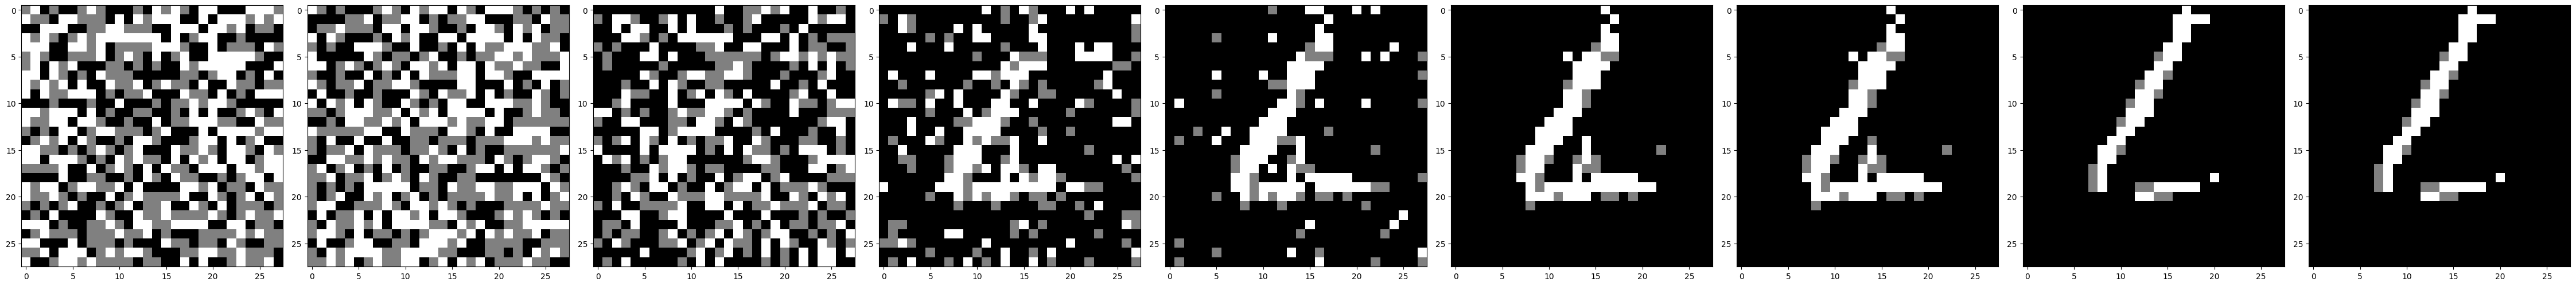

In [24]:
import matplotlib.pyplot as plt
import numpy as np

# Sample data for demonstration
num_plots = len(Xs)  # Number of scatter plots
data = [np.random.rand(50) for _ in range(num_plots)]  # Generate random data for each plot

# Create individual scatter plots
plt.figure(figsize=(num_plots*5, 5))

for i in range(num_plots ):
    plt.subplot(1, num_plots, i+1)  # 1 row, 'num_plots' columns, position 'i+1'
    plt.imshow(Xs[i].data.squeeze().cpu().numpy(), cmap="gray")
    plt.title(f'')

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

In [26]:
Samples = []
for i in range (5*5):
  s, all = model.sample(42)
  Samples.append(s)


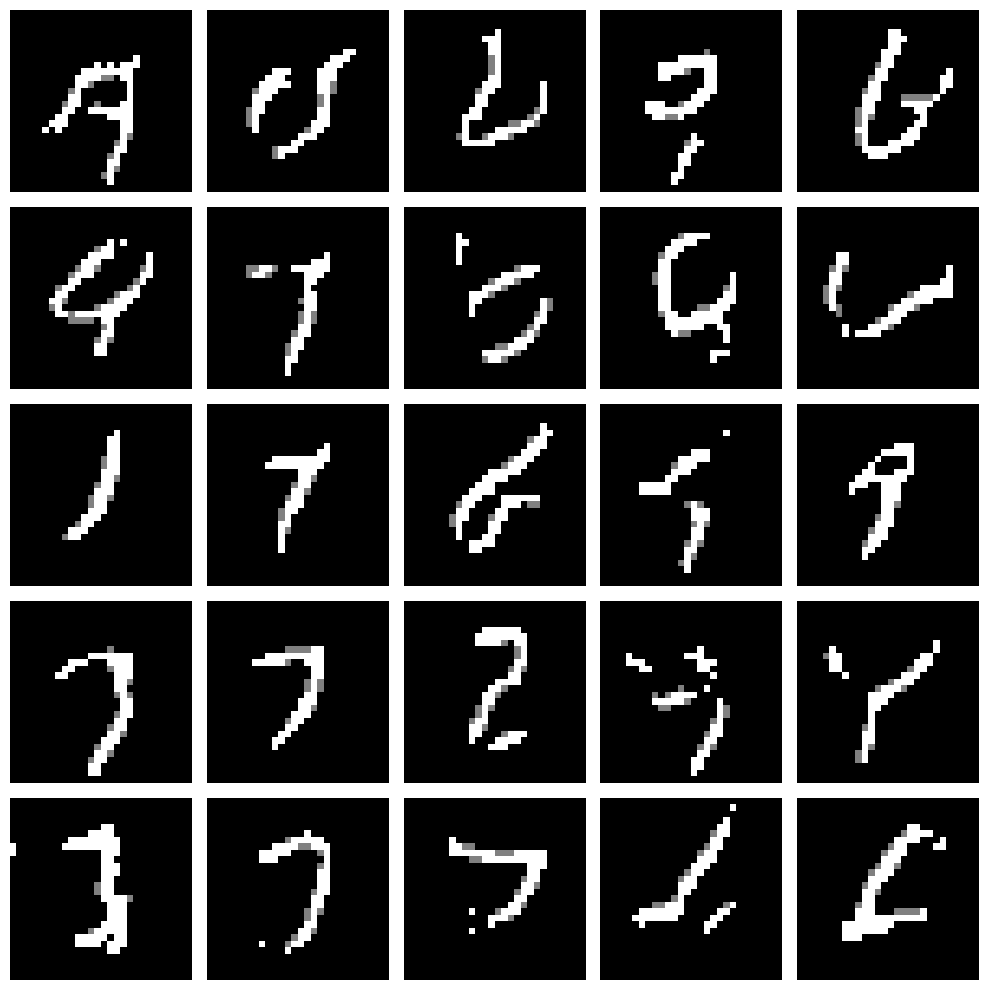

In [27]:
# Function to display a gallery of images
def show_images(images):
    num_images = len(images)
    rows = int(num_images**0.5)
    cols = (num_images + rows - 1) // rows

    fig, axes = plt.subplots(rows, cols, figsize=(10, 10))

    for i, ax in enumerate(axes.flatten()):
        if i < num_images:
            img = images[i]
            ax.imshow(img.squeeze().cpu().numpy(), cmap="gray")
            ax.axis('off')
        else:
            ax.axis('off')  # Hide axis for empty subplots

    plt.tight_layout()
    plt.show()

# Display the gallery of images
show_images(Samples)

#let's try Absorbing transition

In [28]:
# @title Training
num_hidden_dim = 8 # @param {type:"number"}
num_bins = 3 # @param {type:"integer"}
diffusion_steps = 127 # @param {type:"integer"}
transition_type = "absorbing" # @param ["uniform", "absorbing"]
num_epochs = 20 # @param {type:"integer"}
batch_size = 120 # @param {type:"integer"}

dataset = DiscretizeMnist(num_bins=3)

loader = torch.utils.data.DataLoader(
    dataset, batch_size=batch_size, num_workers=8, shuffle=True
)

# now we create the model
model = MnistTrainer(hybrid_coeff =0.0001 ,hidden_dim=num_hidden_dim, num_bins=num_bins, nb_time_steps=diffusion_steps,transitionType = transition_type)

optimizer = torch.optim.Adam(model.model.parameters(), lr=0.01)

def set_global_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Set a global seed
set_global_seed(42312)


for epoch in range(num_epochs):
    # model.train()  # Set the model to training mode
    with tqdm(loader, desc=f'Epoch {epoch+1}/{num_epochs}', dynamic_ncols=True) as t:

      for batch_data, batch_labels in loader:
          # Zero the gradients
          optimizer.zero_grad()

          # Forward pass
          loss = model.training_step((batch_data.to(device),batch_labels),None)


          # Backward pass
          loss.backward()

          # Update the weights
          optimizer.step()


          t.update(1)
          t.set_postfix(loss=loss.item())

      if epoch %3==0:
        model.on_train_epoch_end()


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 1/20:   0%|          | 2/500 [00:01<08:54,  1.07s/it, loss=1.07]

tensor(1.5431, device='cuda:0', dtype=torch.float64, grad_fn=<SumBackward0>)


Epoch 1/20:  21%|██        | 103/500 [00:08<00:28, 13.94it/s, loss=0.263]

tensor(1.0599, device='cuda:0', dtype=torch.float64, grad_fn=<SumBackward0>)


Epoch 1/20:  41%|████      | 203/500 [00:17<00:21, 13.82it/s, loss=0.302]

tensor(0.2474, device='cuda:0', dtype=torch.float64, grad_fn=<SumBackward0>)


Epoch 1/20:  60%|██████    | 302/500 [00:28<00:31,  6.38it/s, loss=0.362]

tensor(0.3623, device='cuda:0', dtype=torch.float64, grad_fn=<SumBackward0>)


Epoch 1/20:  80%|████████  | 402/500 [00:38<00:09,  9.93it/s, loss=0.332]

tensor(0.2809, device='cuda:0', dtype=torch.float64, grad_fn=<SumBackward0>)


Epoch 2/20:   0%|          | 2/500 [00:01<07:41,  1.08it/s, loss=0.262]

tensor(0.3252, device='cuda:0', dtype=torch.float64, grad_fn=<SumBackward0>)


Epoch 2/20:  21%|██        | 103/500 [00:08<00:29, 13.66it/s, loss=0.266]

tensor(0.2302, device='cuda:0', dtype=torch.float64, grad_fn=<SumBackward0>)


Epoch 2/20:  40%|████      | 202/500 [00:20<00:37,  7.86it/s, loss=0.23] 

tensor(0.2254, device='cuda:0', dtype=torch.float64, grad_fn=<SumBackward0>)


Epoch 2/20:  61%|██████    | 303/500 [00:28<00:14, 13.90it/s, loss=0.216]

tensor(0.2672, device='cuda:0', dtype=torch.float64, grad_fn=<SumBackward0>)


Epoch 2/20:  80%|████████  | 402/500 [00:35<00:07, 13.58it/s, loss=0.239]

tensor(0.2057, device='cuda:0', dtype=torch.float64, grad_fn=<SumBackward0>)


Epoch 3/20:   1%|          | 3/500 [00:00<02:07,  3.91it/s, loss=0.233]

tensor(0.2227, device='cuda:0', dtype=torch.float64, grad_fn=<SumBackward0>)


Epoch 3/20:  21%|██        | 103/500 [00:08<00:28, 13.88it/s, loss=0.253]

tensor(0.2267, device='cuda:0', dtype=torch.float64, grad_fn=<SumBackward0>)


Epoch 3/20:  41%|████      | 203/500 [00:15<00:21, 13.61it/s, loss=0.216]

tensor(0.2099, device='cuda:0', dtype=torch.float64, grad_fn=<SumBackward0>)


Epoch 3/20:  61%|██████    | 303/500 [00:23<00:14, 13.83it/s, loss=0.219]

tensor(0.2094, device='cuda:0', dtype=torch.float64, grad_fn=<SumBackward0>)


Epoch 3/20:  80%|████████  | 402/500 [00:31<00:10,  9.80it/s, loss=0.201]

tensor(0.2034, device='cuda:0', dtype=torch.float64, grad_fn=<SumBackward0>)


Epoch 4/20:   1%|          | 3/500 [00:00<02:05,  3.95it/s, loss=0.229]

tensor(0.2178, device='cuda:0', dtype=torch.float64, grad_fn=<SumBackward0>)


Epoch 4/20:  21%|██        | 103/500 [00:08<00:28, 13.97it/s, loss=0.199]

tensor(0.2099, device='cuda:0', dtype=torch.float64, grad_fn=<SumBackward0>)


Epoch 4/20:  40%|████      | 202/500 [00:16<00:26, 11.05it/s, loss=0.224]

tensor(0.2035, device='cuda:0', dtype=torch.float64, grad_fn=<SumBackward0>)


Epoch 4/20:  61%|██████    | 303/500 [00:24<00:14, 13.94it/s, loss=0.187]

tensor(0.1924, device='cuda:0', dtype=torch.float64, grad_fn=<SumBackward0>)


Epoch 4/20:  81%|████████  | 403/500 [00:32<00:07, 13.59it/s, loss=0.188]

tensor(0.1855, device='cuda:0', dtype=torch.float64, grad_fn=<SumBackward0>)


Epoch 5/20:   0%|          | 2/500 [00:01<08:20,  1.01s/it, loss=0.205]

tensor(0.1978, device='cuda:0', dtype=torch.float64, grad_fn=<SumBackward0>)


Epoch 5/20:  21%|██        | 103/500 [00:08<00:28, 13.80it/s, loss=0.204]

tensor(0.2237, device='cuda:0', dtype=torch.float64, grad_fn=<SumBackward0>)


Epoch 5/20:  41%|████      | 203/500 [00:16<00:21, 13.82it/s, loss=0.18] 

tensor(0.1950, device='cuda:0', dtype=torch.float64, grad_fn=<SumBackward0>)


Epoch 5/20:  60%|██████    | 302/500 [00:24<00:17, 11.09it/s, loss=0.203]

tensor(0.2143, device='cuda:0', dtype=torch.float64, grad_fn=<SumBackward0>)


Epoch 5/20:  81%|████████  | 403/500 [00:31<00:06, 14.09it/s, loss=0.192]

tensor(0.2009, device='cuda:0', dtype=torch.float64, grad_fn=<SumBackward0>)


Epoch 6/20:   1%|          | 3/500 [00:00<02:10,  3.79it/s, loss=0.203]

tensor(0.2142, device='cuda:0', dtype=torch.float64, grad_fn=<SumBackward0>)


Epoch 6/20:  21%|██        | 103/500 [00:08<00:29, 13.50it/s, loss=0.183]

tensor(0.1933, device='cuda:0', dtype=torch.float64, grad_fn=<SumBackward0>)


Epoch 6/20:  41%|████      | 203/500 [00:16<00:21, 13.93it/s, loss=0.188]

tensor(0.1824, device='cuda:0', dtype=torch.float64, grad_fn=<SumBackward0>)


Epoch 6/20:  61%|██████    | 303/500 [00:24<00:15, 12.92it/s, loss=0.194]

tensor(0.2002, device='cuda:0', dtype=torch.float64, grad_fn=<SumBackward0>)


Epoch 6/20:  81%|████████  | 403/500 [00:31<00:07, 13.85it/s, loss=0.204]

tensor(0.1967, device='cuda:0', dtype=torch.float64, grad_fn=<SumBackward0>)


Epoch 7/20:   0%|          | 2/500 [00:00<06:24,  1.29it/s, loss=0.191]

tensor(0.2002, device='cuda:0', dtype=torch.float64, grad_fn=<SumBackward0>)


Epoch 7/20:  21%|██        | 103/500 [00:08<00:28, 13.83it/s, loss=0.189]

tensor(0.2024, device='cuda:0', dtype=torch.float64, grad_fn=<SumBackward0>)


Epoch 7/20:  41%|████      | 203/500 [00:16<00:23, 12.81it/s, loss=0.192]

tensor(0.1875, device='cuda:0', dtype=torch.float64, grad_fn=<SumBackward0>)


Epoch 7/20:  61%|██████    | 303/500 [00:24<00:14, 13.42it/s, loss=0.179]

tensor(0.1780, device='cuda:0', dtype=torch.float64, grad_fn=<SumBackward0>)


Epoch 7/20:  81%|████████  | 403/500 [00:32<00:07, 12.20it/s, loss=0.174]

tensor(0.1895, device='cuda:0', dtype=torch.float64, grad_fn=<SumBackward0>)


Epoch 8/20:   0%|          | 2/500 [00:01<04:48,  1.73it/s, loss=0.186]

tensor(0.1842, device='cuda:0', dtype=torch.float64, grad_fn=<SumBackward0>)


Epoch 8/20:  21%|██        | 103/500 [00:09<00:28, 13.96it/s, loss=0.2]  

tensor(0.1869, device='cuda:0', dtype=torch.float64, grad_fn=<SumBackward0>)


Epoch 8/20:  41%|████      | 203/500 [00:17<00:21, 13.77it/s, loss=0.21] 

tensor(0.1732, device='cuda:0', dtype=torch.float64, grad_fn=<SumBackward0>)


Epoch 8/20:  61%|██████    | 303/500 [00:24<00:14, 13.87it/s, loss=0.169]

tensor(0.1843, device='cuda:0', dtype=torch.float64, grad_fn=<SumBackward0>)


Epoch 8/20:  81%|████████  | 403/500 [00:32<00:07, 13.10it/s, loss=0.194]

tensor(0.1995, device='cuda:0', dtype=torch.float64, grad_fn=<SumBackward0>)


Epoch 9/20:   0%|          | 2/500 [00:00<06:32,  1.27it/s, loss=0.16] 

tensor(0.1863, device='cuda:0', dtype=torch.float64, grad_fn=<SumBackward0>)


Epoch 9/20:  21%|██        | 103/500 [00:08<00:28, 13.94it/s, loss=0.177]

tensor(0.1889, device='cuda:0', dtype=torch.float64, grad_fn=<SumBackward0>)


Epoch 9/20:  41%|████      | 203/500 [00:16<00:21, 13.68it/s, loss=0.211]

tensor(0.1922, device='cuda:0', dtype=torch.float64, grad_fn=<SumBackward0>)


Epoch 9/20:  60%|██████    | 302/500 [00:23<00:19, 10.24it/s, loss=0.183]

tensor(0.1932, device='cuda:0', dtype=torch.float64, grad_fn=<SumBackward0>)


Epoch 9/20:  81%|████████  | 403/500 [00:31<00:07, 13.30it/s, loss=0.196]

tensor(0.1738, device='cuda:0', dtype=torch.float64, grad_fn=<SumBackward0>)


Epoch 10/20:   1%|          | 3/500 [00:00<02:10,  3.80it/s, loss=0.201]

tensor(0.1745, device='cuda:0', dtype=torch.float64, grad_fn=<SumBackward0>)


Epoch 10/20:  20%|██        | 102/500 [00:08<00:34, 11.66it/s, loss=0.201]

tensor(0.1660, device='cuda:0', dtype=torch.float64, grad_fn=<SumBackward0>)


Epoch 10/20:  41%|████      | 203/500 [00:16<00:21, 13.86it/s, loss=0.17] 

tensor(0.1735, device='cuda:0', dtype=torch.float64, grad_fn=<SumBackward0>)


Epoch 10/20:  61%|██████    | 303/500 [00:24<00:14, 13.36it/s, loss=0.188]

tensor(0.1762, device='cuda:0', dtype=torch.float64, grad_fn=<SumBackward0>)


Epoch 10/20:  81%|████████  | 403/500 [00:31<00:07, 13.57it/s, loss=0.195]

tensor(0.1866, device='cuda:0', dtype=torch.float64, grad_fn=<SumBackward0>)


Epoch 11/20:   0%|          | 1/500 [00:00<06:12,  1.34it/s, loss=0.185]

tensor(0.1846, device='cuda:0', dtype=torch.float64, grad_fn=<SumBackward0>)


Epoch 11/20:  21%|██        | 103/500 [00:09<00:29, 13.55it/s, loss=0.165]

tensor(0.1714, device='cuda:0', dtype=torch.float64, grad_fn=<SumBackward0>)


Epoch 11/20:  41%|████      | 203/500 [00:16<00:23, 12.88it/s, loss=0.181]

tensor(0.1952, device='cuda:0', dtype=torch.float64, grad_fn=<SumBackward0>)


Epoch 11/20:  61%|██████    | 303/500 [00:24<00:14, 13.28it/s, loss=0.187]

tensor(0.2188, device='cuda:0', dtype=torch.float64, grad_fn=<SumBackward0>)


Epoch 11/20:  81%|████████  | 403/500 [00:32<00:07, 12.45it/s, loss=0.173]

tensor(0.1909, device='cuda:0', dtype=torch.float64, grad_fn=<SumBackward0>)


Epoch 12/20:   1%|          | 3/500 [00:00<02:09,  3.84it/s, loss=0.193]

tensor(0.1980, device='cuda:0', dtype=torch.float64, grad_fn=<SumBackward0>)


Epoch 12/20:  21%|██        | 103/500 [00:08<00:29, 13.48it/s, loss=0.179]

tensor(0.1861, device='cuda:0', dtype=torch.float64, grad_fn=<SumBackward0>)


Epoch 12/20:  41%|████      | 203/500 [00:17<00:28, 10.37it/s, loss=0.16] 

tensor(0.1936, device='cuda:0', dtype=torch.float64, grad_fn=<SumBackward0>)


Epoch 12/20:  61%|██████    | 303/500 [00:24<00:14, 13.76it/s, loss=0.171]

tensor(0.1706, device='cuda:0', dtype=torch.float64, grad_fn=<SumBackward0>)


Epoch 12/20:  81%|████████  | 403/500 [00:32<00:07, 13.86it/s, loss=0.186]

tensor(0.1879, device='cuda:0', dtype=torch.float64, grad_fn=<SumBackward0>)


Epoch 13/20:   0%|          | 2/500 [00:01<10:22,  1.25s/it, loss=0.169]

tensor(0.1691, device='cuda:0', dtype=torch.float64, grad_fn=<SumBackward0>)


Epoch 13/20:  21%|██        | 103/500 [00:08<00:28, 13.87it/s, loss=0.191]

tensor(0.1740, device='cuda:0', dtype=torch.float64, grad_fn=<SumBackward0>)


Epoch 13/20:  41%|████      | 203/500 [00:16<00:22, 13.14it/s, loss=0.177]

tensor(0.1940, device='cuda:0', dtype=torch.float64, grad_fn=<SumBackward0>)


Epoch 13/20:  61%|██████    | 303/500 [00:24<00:14, 13.56it/s, loss=0.155]

tensor(0.2034, device='cuda:0', dtype=torch.float64, grad_fn=<SumBackward0>)


Epoch 13/20:  81%|████████  | 403/500 [00:32<00:07, 13.26it/s, loss=0.177]

tensor(0.1947, device='cuda:0', dtype=torch.float64, grad_fn=<SumBackward0>)


Epoch 14/20:   0%|          | 2/500 [00:00<06:46,  1.23it/s, loss=0.174]

tensor(0.1750, device='cuda:0', dtype=torch.float64, grad_fn=<SumBackward0>)


Epoch 14/20:  21%|██        | 103/500 [00:09<00:33, 11.74it/s, loss=0.189]

tensor(0.1953, device='cuda:0', dtype=torch.float64, grad_fn=<SumBackward0>)


Epoch 14/20:  41%|████      | 203/500 [00:16<00:21, 13.93it/s, loss=0.184]

tensor(0.1931, device='cuda:0', dtype=torch.float64, grad_fn=<SumBackward0>)


Epoch 14/20:  61%|██████    | 303/500 [00:24<00:14, 13.47it/s, loss=0.189]

tensor(0.1718, device='cuda:0', dtype=torch.float64, grad_fn=<SumBackward0>)


Epoch 14/20:  80%|████████  | 402/500 [00:32<00:09, 10.65it/s, loss=0.164]

tensor(0.1993, device='cuda:0', dtype=torch.float64, grad_fn=<SumBackward0>)


Epoch 15/20:   1%|          | 3/500 [00:00<02:10,  3.81it/s, loss=0.171]

tensor(0.1953, device='cuda:0', dtype=torch.float64, grad_fn=<SumBackward0>)


Epoch 15/20:  21%|██        | 103/500 [00:09<00:30, 13.22it/s, loss=0.161]

tensor(0.1971, device='cuda:0', dtype=torch.float64, grad_fn=<SumBackward0>)


Epoch 15/20:  40%|████      | 202/500 [00:16<00:24, 12.35it/s, loss=0.186]

tensor(0.1629, device='cuda:0', dtype=torch.float64, grad_fn=<SumBackward0>)


Epoch 15/20:  61%|██████    | 303/500 [00:24<00:14, 13.41it/s, loss=0.172]

tensor(0.1762, device='cuda:0', dtype=torch.float64, grad_fn=<SumBackward0>)


Epoch 15/20:  81%|████████  | 403/500 [00:33<00:07, 12.94it/s, loss=0.171]

tensor(0.1922, device='cuda:0', dtype=torch.float64, grad_fn=<SumBackward0>)


Epoch 16/20:   1%|          | 3/500 [00:00<02:09,  3.84it/s, loss=0.18] 

tensor(0.2023, device='cuda:0', dtype=torch.float64, grad_fn=<SumBackward0>)


Epoch 16/20:  21%|██        | 103/500 [00:09<00:28, 13.71it/s, loss=0.167]

tensor(0.1934, device='cuda:0', dtype=torch.float64, grad_fn=<SumBackward0>)


Epoch 16/20:  41%|████      | 203/500 [00:17<00:24, 12.27it/s, loss=0.178]

tensor(0.1635, device='cuda:0', dtype=torch.float64, grad_fn=<SumBackward0>)


Epoch 16/20:  61%|██████    | 303/500 [00:24<00:15, 13.06it/s, loss=0.172]

tensor(0.1788, device='cuda:0', dtype=torch.float64, grad_fn=<SumBackward0>)


Epoch 16/20:  81%|████████  | 403/500 [00:32<00:07, 13.41it/s, loss=0.17] 

tensor(0.2118, device='cuda:0', dtype=torch.float64, grad_fn=<SumBackward0>)


Epoch 17/20:   0%|          | 2/500 [00:00<06:40,  1.24it/s, loss=0.186]

tensor(0.1680, device='cuda:0', dtype=torch.float64, grad_fn=<SumBackward0>)


Epoch 17/20:  20%|██        | 102/500 [00:08<00:35, 11.21it/s, loss=0.167]

tensor(0.1788, device='cuda:0', dtype=torch.float64, grad_fn=<SumBackward0>)


Epoch 17/20:  41%|████      | 203/500 [00:16<00:21, 13.83it/s, loss=0.172]

tensor(0.1718, device='cuda:0', dtype=torch.float64, grad_fn=<SumBackward0>)


Epoch 17/20:  61%|██████    | 303/500 [00:24<00:14, 13.29it/s, loss=0.18] 

tensor(0.1707, device='cuda:0', dtype=torch.float64, grad_fn=<SumBackward0>)


Epoch 17/20:  81%|████████  | 403/500 [00:32<00:07, 13.39it/s, loss=0.183]

tensor(0.1878, device='cuda:0', dtype=torch.float64, grad_fn=<SumBackward0>)


Epoch 18/20:   1%|          | 3/500 [00:00<02:12,  3.75it/s, loss=0.197]

tensor(0.1863, device='cuda:0', dtype=torch.float64, grad_fn=<SumBackward0>)


Epoch 18/20:  21%|██        | 103/500 [00:08<00:32, 12.05it/s, loss=0.177]

tensor(0.1791, device='cuda:0', dtype=torch.float64, grad_fn=<SumBackward0>)


Epoch 18/20:  41%|████      | 203/500 [00:16<00:21, 13.73it/s, loss=0.169]

tensor(0.1736, device='cuda:0', dtype=torch.float64, grad_fn=<SumBackward0>)


Epoch 18/20:  61%|██████    | 303/500 [00:24<00:15, 12.77it/s, loss=0.171]

tensor(0.1742, device='cuda:0', dtype=torch.float64, grad_fn=<SumBackward0>)


Epoch 18/20:  80%|████████  | 402/500 [00:32<00:09,  9.83it/s, loss=0.171]

tensor(0.1850, device='cuda:0', dtype=torch.float64, grad_fn=<SumBackward0>)


Epoch 19/20:   1%|          | 3/500 [00:00<02:08,  3.87it/s, loss=0.157]

tensor(0.1707, device='cuda:0', dtype=torch.float64, grad_fn=<SumBackward0>)


Epoch 19/20:  21%|██        | 103/500 [00:09<00:29, 13.35it/s, loss=0.17] 

tensor(0.1672, device='cuda:0', dtype=torch.float64, grad_fn=<SumBackward0>)


Epoch 19/20:  40%|████      | 202/500 [00:16<00:28, 10.62it/s, loss=0.177]

tensor(0.1614, device='cuda:0', dtype=torch.float64, grad_fn=<SumBackward0>)


Epoch 19/20:  61%|██████    | 303/500 [00:24<00:14, 13.58it/s, loss=0.182]

tensor(0.1794, device='cuda:0', dtype=torch.float64, grad_fn=<SumBackward0>)


Epoch 19/20:  81%|████████  | 403/500 [00:32<00:07, 12.84it/s, loss=0.191]

tensor(0.1728, device='cuda:0', dtype=torch.float64, grad_fn=<SumBackward0>)


Epoch 20/20:   0%|          | 2/500 [00:01<03:37,  2.29it/s, loss=0.172]

tensor(0.1626, device='cuda:0', dtype=torch.float64, grad_fn=<SumBackward0>)


Epoch 20/20:  21%|██        | 103/500 [00:08<00:29, 13.29it/s, loss=0.189]

tensor(0.2008, device='cuda:0', dtype=torch.float64, grad_fn=<SumBackward0>)


Epoch 20/20:  41%|████      | 203/500 [00:16<00:21, 13.81it/s, loss=0.149]

tensor(0.1777, device='cuda:0', dtype=torch.float64, grad_fn=<SumBackward0>)


Epoch 20/20:  61%|██████    | 303/500 [00:24<00:15, 12.91it/s, loss=0.195]

tensor(0.1625, device='cuda:0', dtype=torch.float64, grad_fn=<SumBackward0>)


Epoch 20/20:  81%|████████  | 403/500 [00:32<00:07, 13.16it/s, loss=0.168]

tensor(0.1833, device='cuda:0', dtype=torch.float64, grad_fn=<SumBackward0>)


Epoch 20/20: 100%|██████████| 500/500 [00:40<00:00, 12.38it/s, loss=0.159]


In [29]:
_, Xs = model.sample(42)

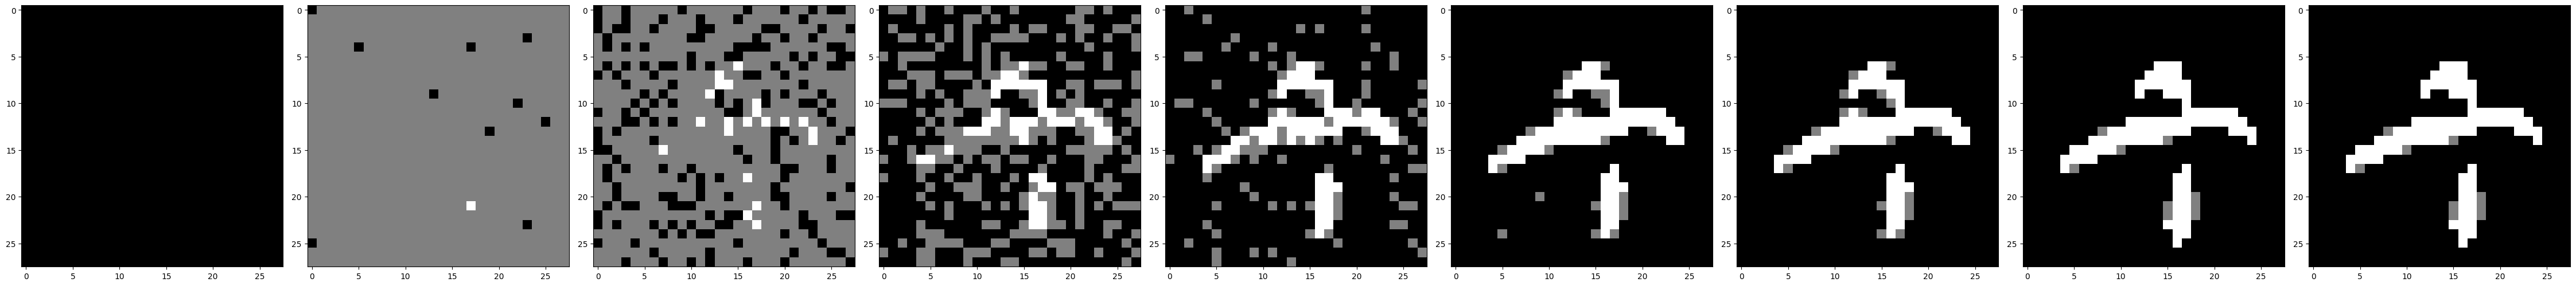

In [30]:
import matplotlib.pyplot as plt
import numpy as np

# Sample data for demonstration
num_plots = len(Xs)  # Number of scatter plots
data = [np.random.rand(50) for _ in range(num_plots)]  # Generate random data for each plot

# Create individual scatter plots
plt.figure(figsize=(num_plots*5, 5))

for i in range(num_plots ):
    plt.subplot(1, num_plots, i+1)  # 1 row, 'num_plots' columns, position 'i+1'
    plt.imshow(Xs[i].data.squeeze().cpu().numpy(), cmap="gray")
    plt.title(f'')

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

In [31]:
Samples = []
for i in range (5*5):
  s, all = model.sample(42)
  Samples.append(s)


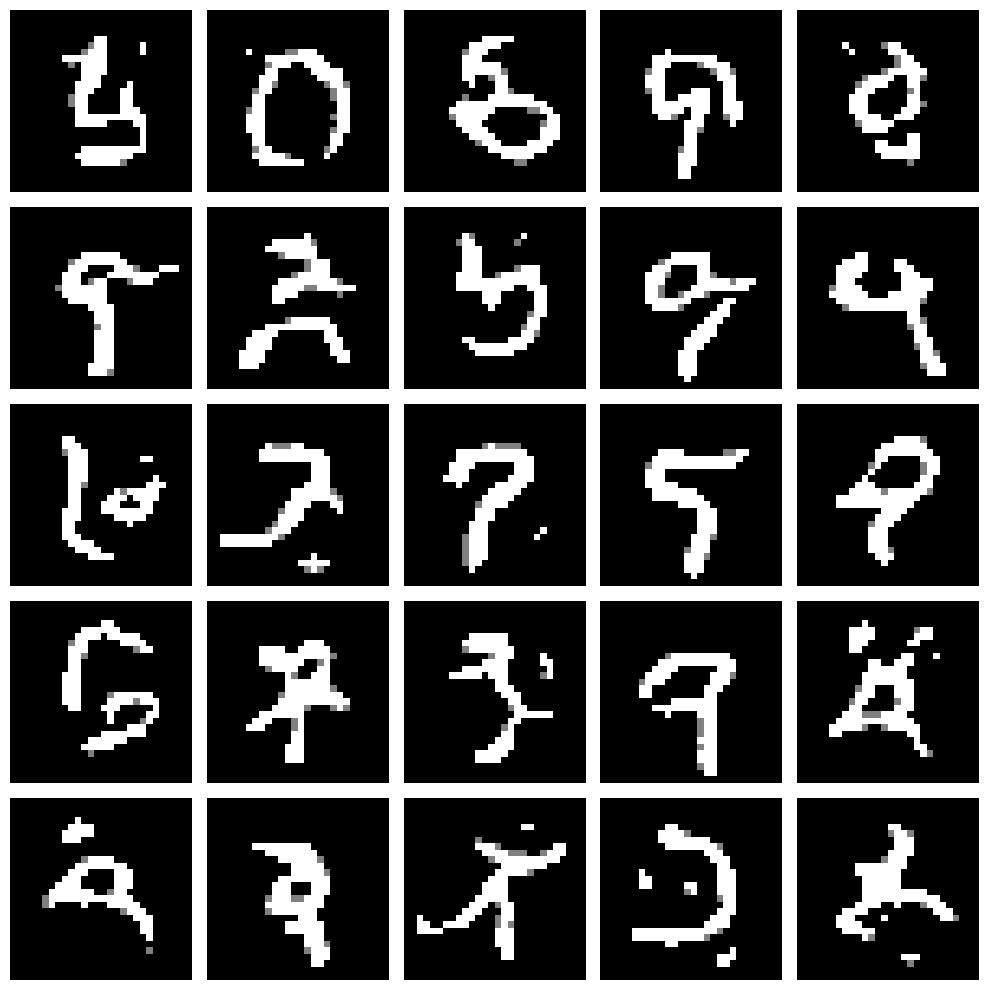

In [32]:
# Function to display a gallery of images
def show_images(images):
    num_images = len(images)
    rows = int(num_images**0.5)
    cols = (num_images + rows - 1) // rows

    fig, axes = plt.subplots(rows, cols, figsize=(10, 10))

    for i, ax in enumerate(axes.flatten()):
        if i < num_images:
            img = images[i]
            ax.imshow(img.squeeze().cpu().numpy(), cmap="gray")
            ax.axis('off')
        else:
            ax.axis('off')  # Hide axis for empty subplots

    plt.tight_layout()
    plt.show()

# Display the gallery of images
show_images(Samples)

#**Conclusion**


In this notebook, we delved into the D3PM paper [paper](https://arxiv.org/abs/2107.03006), which presents an intriguing approach to discretizing the diffusion process while incorporating a versatile corruption mechanism tailored to specific applications.

The paper certainly sparked curiosity, especially regarding concepts like the absorbing transition. What caught my attention is the notion of X$inf$ (the noisy image at infinity) representing a singular value, essentially an image where all pixels converge to an absorbing category. This concept could hold significance in areas like consistency models or one-step diffusion scenarios.

However, my training experience with this method was less than ideal. Instability was a recurring issue, particularly when employing the Absorbing transition, leading to occasional collapses in model outputs.

Overall, while this approach demonstrates effectiveness with inherently discrete data, it still falls short in domains such as images and text compared to established state-of-the-art techniques. Nevertheless, it undoubtedly paves the way for further exploration into the realms of discretization, corruption processes, and the iterative refinement inherent in diffusion methodologies.

